## Библиотеки и функции

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
import requests
import os
import csv
import seaborn as sns
import math
import statistics
sns.set()
import warnings  
warnings.filterwarnings('ignore')
%matplotlib inline

import prometheus_api

In [189]:
def nan_fouder(df: pd.core.frame.DataFrame, metric:str):
    df_1 = df[df[metric].isnull()]
    if df_1.shape[0] == 0:
        return pd.DataFrame(columns=['time_start','time_end','index_start','index_end'])
    df_1['index_1'] = range(df_1.shape[0])
    df_result = pd.DataFrame(columns=['time_start','time_end','index_start','index_end'])
    i = 0
   
    while True:
        
        tmp = df_1.index.min() - df_1['index_1'].min()
        df_tmp = df_1[df_1.index - df_1['index_1'] == tmp]
        df_result.loc[i]=[df_tmp['time'][df_tmp.index.min()],df_tmp['time'][df_tmp.index.min()+df_tmp.shape[0]-1],df_tmp.index[0],df_tmp.index[df_tmp.shape[0]-1]]
        if df_tmp.shape[0] == df_1.shape[0]:
            break
        else:
            i += 1
            df_1 = df_1[df_1.index>df_tmp.index[df_tmp.shape[0]-1]]
    return df_result
  

In [190]:
def nan_droper(df: pd.core.frame.DataFrame, df_1: pd.core.frame.DataFrame, metric:str):
    for i in range(df_1.shape[0]):    
        index_to_drop = range(df_1.loc[i].index_start, df_1.loc[i].index_end+1)
        df = df.drop(list(index_to_drop))
    df.index = np.arange(len(df))
    return df

In [191]:
def reload_fouder(df: pd.core.frame.DataFrame, metric:str, num:int):
    
    df_1 = df
    df_1['metric_1']=df_1[metric].shift(-1)
    df_1 = df_1[df_1['metric_1']-df_1[metric]<-num]
    
    return df_1
    

In [192]:
def regr_coef(df: pd.core.frame.DataFrame, metric:str,ind1:int,ind2:int):
    ind1 = int(ind1)
    ind2 = int(ind2)
    df_1 = df[df.index<=ind2]
    df_1 = df_1[df_1.index>=ind1]
    df_1['index'] = range(ind1,ind2+1)
    df_1['xy'] = df_1.apply(lambda x: x['index']*x[metric] , axis=1)
    df_1['x2'] = df_1.apply(lambda x: x['index']**2 , axis=1)
    a = (df_1['xy'].mean()-df_1['index'].mean()*df_1[metric].mean())/(df_1['x2'].mean()-df_1['index'].mean()**2)
    b = (df_1[metric].mean()*df_1['x2'].mean()-df_1['index'].mean()*df_1['xy'].mean())/(df_1['x2'].mean()-df_1['index'].mean()**2)
    plt.plot([ind1,ind2],[a*ind1+b,a*ind2+b],df_1['index'],df_1[metric])
    plt.ylabel('Latancy without restarts')
    plt.xlabel('tact')
    plt.show()
    return [a,
           b]

In [193]:
def new_graph(df: pd.core.frame.DataFrame, df_1: pd.core.frame.DataFrame, metric:str):
    
    df_metric = df[metric]
    
    first_piece = [0,df_1.index.min()]
    last_piece = [df_1.index.max(),df.index.max()]
    
    pairs = []
    for i in range(len(df_1.index)-1):
        pairs.append([df_1.index[i],df_1.index[i+1]])
    
    df_metric_find = df[metric].loc[first_piece[0]:first_piece[1]]
    
    for section in pairs:
        df_metric_new = df_metric.loc[section[0]+1:section[1]]
        df_metric_new = df_metric_new.apply(lambda x: x + df_metric_find.loc[section[0]])
        df_metric_find = pd.concat([df_metric_find,df_metric_new], ignore_index=True)
    df_last = df[metric].loc[last_piece[0]+1:last_piece[1]]
    df_last = df_last.apply(lambda x: x + df_metric_find.loc[last_piece[0]])
    df_metric_find = pd.concat([df_metric_find,df_last], ignore_index=True)    
    df['latancy_without_restarts'] = df_metric_find.values
    return df

In [194]:
def anomaly_with_diff(df: pd.core.frame.DataFrame,metric:str, num: int,num2:int):
    df_1 = df
    df_1['diff'] = df_1[metric].diff()
    df_1['timesmore'] = df_1['diff']/df_1['diff'].mean()
    df_1 = df_1[df_1['diff']/df_1['diff'].mean()>num]
    df_2 = df_1
    
    if df_1.shape[0] == 0:
        return pd.DataFrame(columns=['time_start','time_end','index_start','index_end','times_more','latancy_without_restarts','needed_index'])
    df_1['index_1'] = range(df_1.shape[0])
    df_result = pd.DataFrame(columns=['time_start','time_end','index_start','index_end','times_more','latancy_without_restarts','needed_index'])
    i = 0
   
    while True:
        
        tmp = df_1.index.min() - df_1['index_1'].min()
        df_tmp = df_1[df_1.index - df_1['index_1'] == tmp]
        df_result.loc[i]=[df_tmp['time'][df_tmp.index.min()],
                          df_tmp['time'][df_tmp.index.min()+df_tmp.shape[0]-1],
                          df_tmp.index[0],
                          df_tmp.index[df_tmp.shape[0]-1],
                          df_2['diff'].mean(),
                         df_tmp['latancy_without_restarts'].min().astype(float),
                         df_tmp.index.min().astype(float)]
        if df_tmp.shape[0] == df_1.shape[0]:
            break
        else:
            i += 1
            df_1 = df_1[df_1.index>df_tmp.index[df_tmp.shape[0]-1]]
    for i in range(df_result.shape[0]-1):
        if df_result['index_start'][i+1]-df_result['index_end'][i]<num2:
            df_result['index_start'][i+1] = df_result['index_start'][i]
            df_result['index_end'][i]=df_result['index_end'][i+1]
            df_result['time_start'][i+1] = df_result['time_start'][i]
            df_result['time_end'][i]=df_result['time_end'][i+1]
    df_result.drop_duplicates(subset=['index_start'], keep='first',inplace = True)
    df_result = df_result.reset_index()  
    for i in range(df_result.shape[0]):
        df_tmp = df[df.index<=df_result['index_end'][i]]
        df_result['times_more'][i] = df_tmp[df_tmp.index>=df_result['index_start'][i]]['diff'].mean()/df['diff'].mean()
    return df_result
    
    return df_1
    
    

In [195]:
def showDiv(df: pd.core.frame.DataFrame,metric:str, points):
    point_tmp = points[0]
    for point in points:
        if point!=point_tmp:
            regr_coef(df,metric,point_tmp,point)
            point_tmp = point
    regr_coef(df,metric,point_tmp,df.shape[0]-1)
        

In [196]:
def anomaly_detection(file:str, metric:str,num:int, typ:int, upd_list):
    
    print(metric)
    if type(file) == str:
        df = pd.read_csv(file)
    else:
        df = file
    
    print("\n")
    print ('Метрика: %(metric)s ' % {"metric": metric})
    print("\n")    
    
    nah = nan_fouder(df,metric)
    
    df = nan_droper(df, nah, metric)
    #df.index.name = 'index'
    
    if nah.empty:
        print('Участков отсутсвия данных нет.')
    else:
        print('Участки отсутсвия данных:')
        display(nah)
    print("\n")
    df_perez = reload_fouder(df,metric, 100000)
    if df_perez.empty:
        print('Перезагрузок сервера не было.')
    else:
        print('Моменты перезагрузки сервера:')
        display(df_perez['time'].to_frame())
    print("\n")
    df_summ = new_graph(df, df_perez,metric )
    
    
    if typ == 1:
        df_summ['diff'] = df_summ[metric].diff()
        diff_anomaly = anomaly_with_diff(df_summ, 'latancy_without_restarts',num,30)
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        df_summ.plot(y='latancy_without_restarts',x='time',figsize=(20, 15),title = 'Целевая метрика нарастающим итогом', ax = ax)
        if diff_anomaly.empty:
            print("NO DIFF ANOMALY")
        else:
            diff_anomaly.plot.scatter(y='latancy_without_restarts',x='needed_index', c = 'red', s = 90, figsize=(20, 15),title = 'Целевая метрика нарастающим итогом', ax = ax)
        plt.ylabel('Latancy without restarts')
        plt.xlabel('time')
        plt.show()
        #df_summ.plot.scatter(y='latancy_without_restarts',x = 'index' ,figsize=(20, 15),title = 'Целевая метрика нарастающим итогом')
       # plt.scatter(list(df_perez[metric].index), df_perez[metric].loc[[df_perez[metric].index]], color='orange', s=40, marker='o')
    #print('Делим на участки одинаковой линейности:')
    #showDiv(df_summ,'latancy_without_restarts',points)
    #df_summ['diff'] = df_summ[metric].diff()
    print('Аномалии:')
    #diff_anomaly = anomaly_with_diff(df_summ, 'latancy_without_restarts',num,30)
    display(diff_anomaly[['time_start','time_end','index_start','index_end','times_more']])
    print("\n")
    if typ == 1:
        for i in range(diff_anomaly.shape[0]):
            print('Начало аномалии: %(start)s ' % {"start": diff_anomaly['time_start'][i]})
            print('Конец  аномалии: %(end)s ' % {"end": diff_anomaly['time_end'][i]})
            regr_coef(df_summ,'latancy_without_restarts',diff_anomaly['index_start'][i]-30,diff_anomaly['index_end'][i]+30)
    return [file,nah.shape[0],df_perez.shape[0],diff_anomaly.shape[0]]

In [197]:
def upd_days(df):
    df_with_upd_times = df.fillna(0)
    metrics = []
    for column in df.columns.values:
        if((column !='date_time') & (column != 'time')):
            metrics.append(column)
    list_of_upd = []
    for metric in metrics:
        df_with_upd_times['for_diff'] = df_with_upd_times[metric].shift(-1)
        df_metr_res = df_with_upd_times[
            df_with_upd_times['for_diff']-df_with_upd_times[metric] > 0]
        to_append = "_".join(df_metr_res['date_time'].tolist())
        if (to_append != ''):
            list_of_upd.append(to_append)
        df_with_upd_times.drop(columns=['for_diff'])
    return list_of_upd

In [198]:
def get_df_with_upd(START_TIME, END_TIME, step, upd_features, dcs):
    out = pd.DataFrame(columns = dcs)
    out = out.T
    upd_list_list = []
    for dc in dcs:
        upd_list = []
        for upd_feature in upd_features:
            
            upd_targ = upd_feature + '{dc="'
            dc_part = dc + '", instance="' + dc + '-stor01.vstoragedomain", '
            upd_end = 'job="abgw"}'
            query  = upd_targ + dc_part + upd_end
            
            df_dc_upd = prometheus_api.PrometheusApi.get_normalized_time_series(query, START_TIME, END_TIME, step)
            upd_list = upd_list + upd_days(df_dc_upd)
        upd_list_list.append(upd_list)
    out['upd_datetime'] = upd_list_list
    return out

In [199]:
def anomaly_result(df_info, metric, nums, typ):
    result = pd.DataFrame(columns=['DC','NaN','Dumps','Anomalies'])
    upd_list = []
    if type(df_info) == dict:
        
        START_TIME = df_info['START_TIME']
        END_TIME   = df_info['END_TIME']
        step = df_info['step']
        querys = df_info['querys']
        dcs = df_info['dcs']
        upd_features = df_info['upd_features']
        
        df_with_upd = get_df_with_upd(START_TIME, END_TIME, step, upd_features, dcs)
        for i in range(len(dcs)):
            print('dc =', dcs[i])
            print(df_with_upd.T[dcs[i]].tolist()[0])
            
            query = querys[dcs[i]]
            df = prometheus_api.PrometheusApi.get_normalized_time_series(query, START_TIME, END_TIME, step)
            if df.empty:
                print("For some reasons we can't obtain any data")
                print("For some reasons we can't obtain any data")
                print("For some reasons we can't obtain any data")
                print("For some reasons we can't obtain any data")
            else:
                metric = df.columns[0]
                result.loc[i] = anomaly_detection(df,metric,nums[i],typ, df_with_upd.T[dcs[i]].tolist()[0])
    if type(df_info) == list:
        """
        this mean that df_info is only dcs list
        """
        
        for i in range(len(df_info)):
            file = 'res/' + df_info[i] + '.csv'
            print('dc =', df_info[i])
            result.loc[i] = anomaly_detection(file,metric,nums[i],typ, upd_list)
        return result

Что же я изменил:
1) тепер запуливаем не rec\dc.csv а просто список dc и он сам допишет res\dc.csv
2) чтобы зпустить загрузку с сервака нужно создать dc_info - словарь. Пример создания есть.
3) Так же, чтобы иметь возможность спрашивать данные без участия dc подаём словарь запросов, а в dc можно например положить True_sight или что там было в количестве пользователей
4)

In [200]:
dcs = ['au2-acs1', 
       'eu2-acs1', 
       'eu3-acs1', 
       'eu5-acs1', 
       'eu9-acs1', 
       'jp2-acs1',
       'nissan', 
       'ru2-acs1',
       'us2-acs1', 
       'us3',
       'us3-acs2',
       'us6-acs1',
       'us6-acs2']
nums = [30,
        60,
        21,
        41,
        7,
        20,
        70,
        60,
        65,
        26,
        12,
        27,
        15]
upd_features = [ 'application_build_info',
                'pcs_process_build_info',
                'prometheus_build_info',
                'node_exporter_build_info']
metric = 'abgw_iop_latency_ms_count'
querys = {}
for dc in dcs:
            
    upd_targ = metric + '{dc="'
    dc_part = dc + '", instance="' + dc + '-stor01.vstoragedomain", '
    upd_end = 'err="OK", job="abgw", iop="isync", proxied="0"}'
    querys[dc] = upd_targ + dc_part + upd_end

dc = au2-acs1
[]
abgw_iop_latency_ms_count_dc=au2-acs1_err=OK_instance=au2-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=au2-acs1_err=OK_instance=au2-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
1305,1562740200




NO DIFF ANOMALY


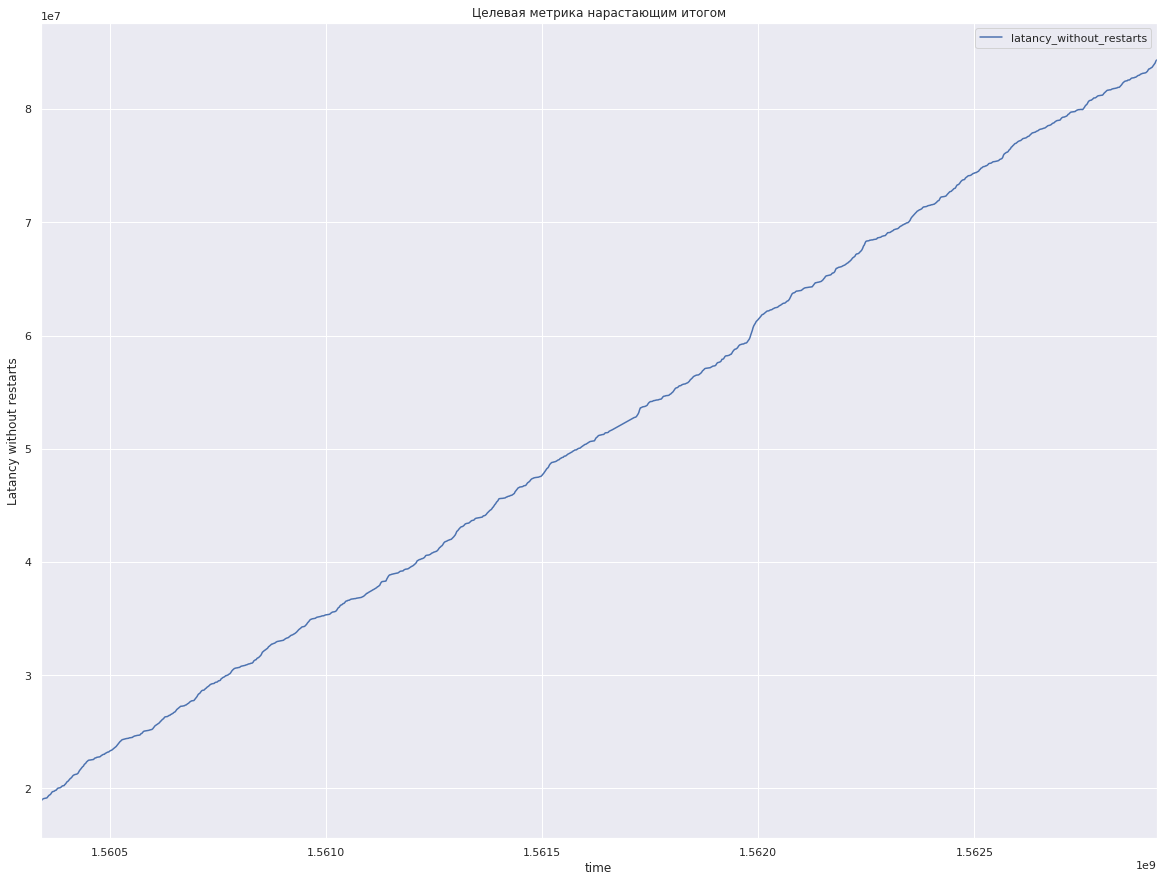

Аномалии:


,time_start,time_end,index_start,index_end,times_more




dc = eu2-acs1
['18/06/2019 13:30:00']
abgw_iop_latency_ms_count_dc=eu2-acs1_err=OK_instance=eu2-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=eu2-acs1_err=OK_instance=eu2-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
218,1560735000
290,1560864600
739,1561721400




NO DIFF ANOMALY


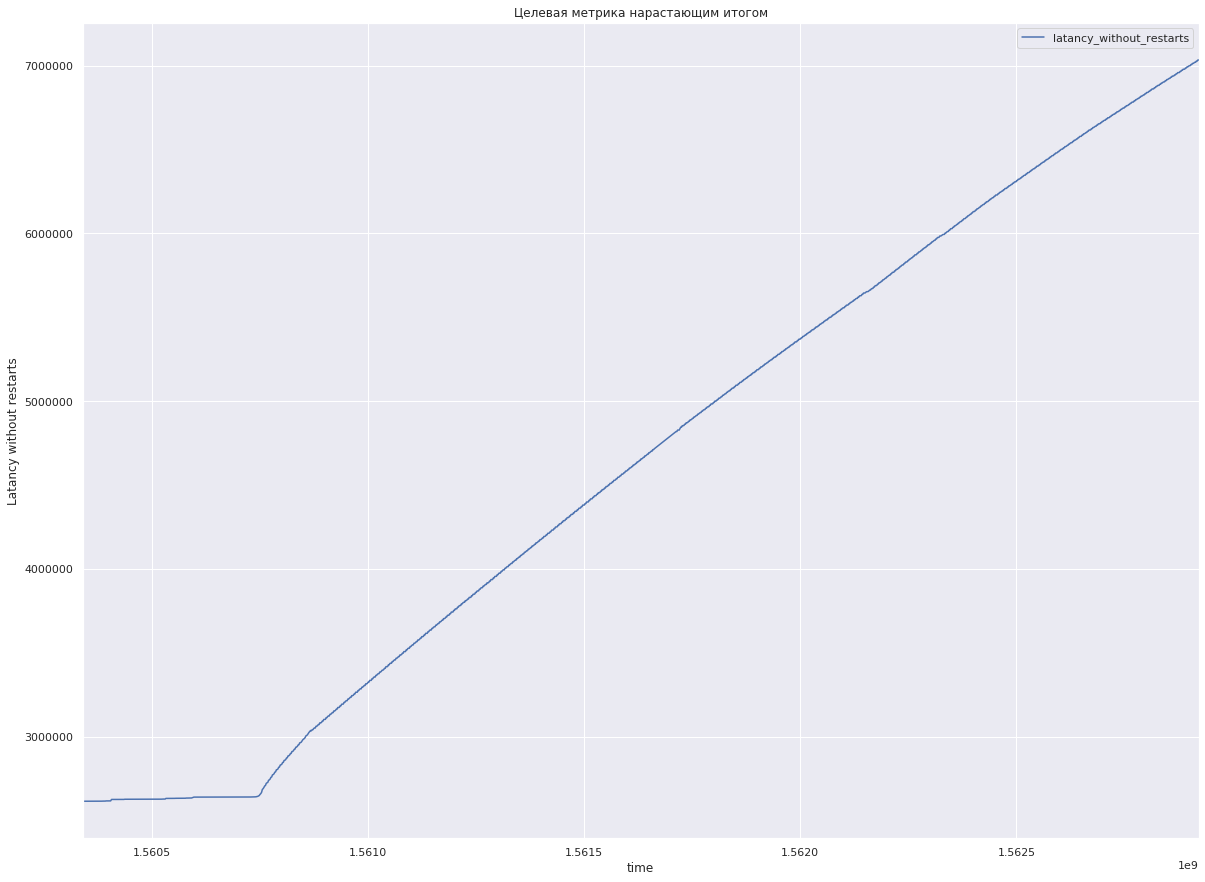

Аномалии:


,time_start,time_end,index_start,index_end,times_more




dc = eu3-acs1
[]
abgw_iop_latency_ms_count_dc=eu3-acs1_err=OK_instance=eu3-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=eu3-acs1_err=OK_instance=eu3-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
1315,1562758200


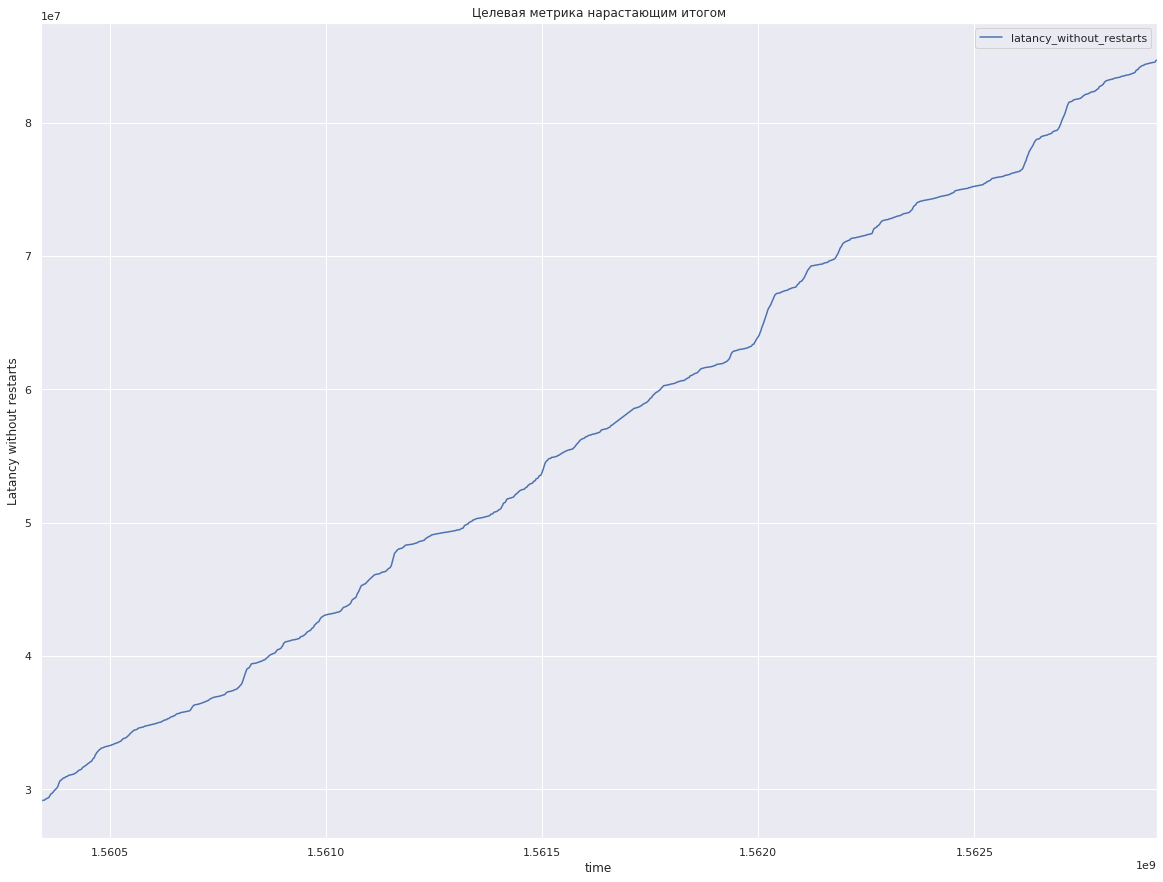

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,1.561712e+09,1.561712e+09,734.0,734.0,31.310675




Начало аномалии: 1561712400.0 
Конец  аномалии: 1561712400.0 


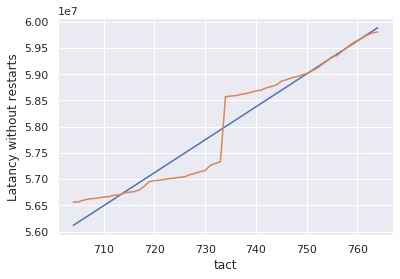

dc = eu5-acs1
[]
abgw_iop_latency_ms_count_dc=eu5-acs1_err=OK_instance=eu5-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=eu5-acs1_err=OK_instance=eu5-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Перезагрузок сервера не было.


NO DIFF ANOMALY


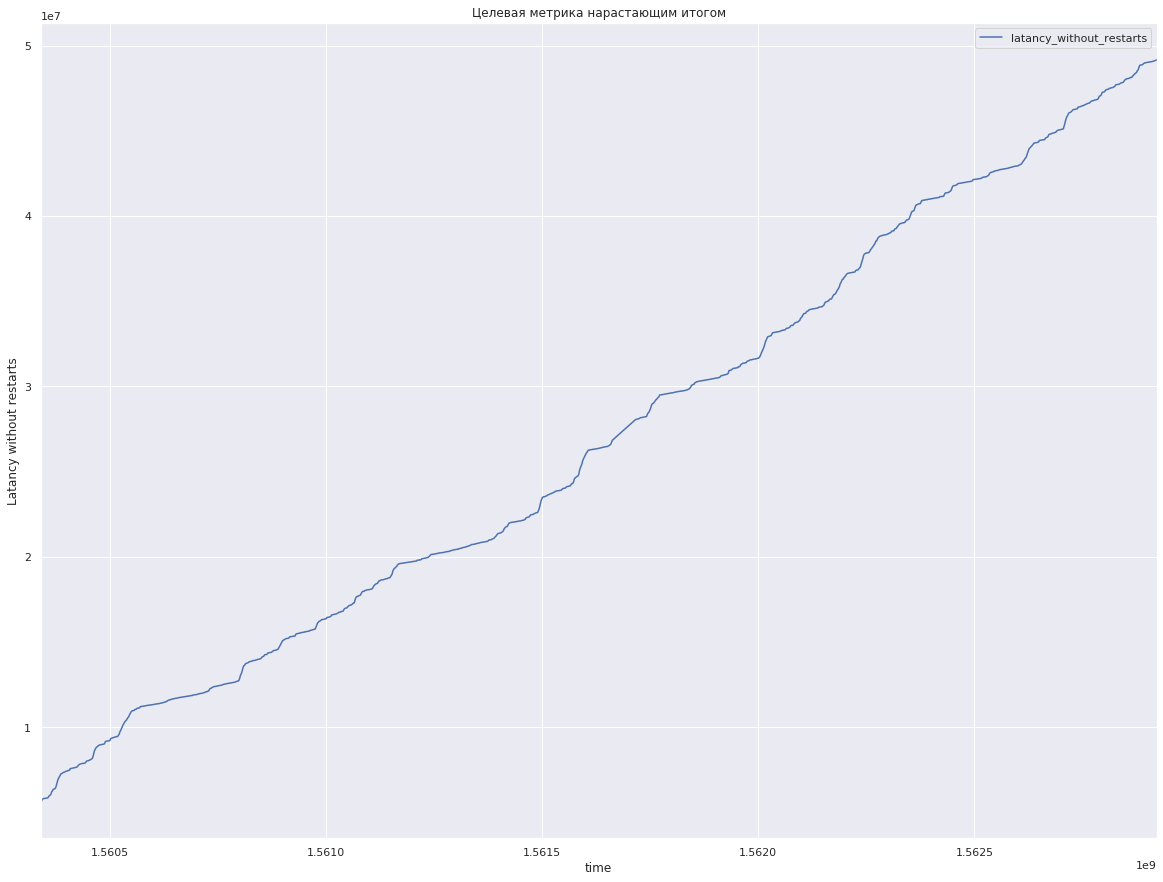

Аномалии:


,time_start,time_end,index_start,index_end,times_more




dc = eu9-acs1
[]
abgw_iop_latency_ms_count_dc=eu9-acs1_err=OK_instance=eu9-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=eu9-acs1_err=OK_instance=eu9-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
0,1560339000
390,1561044600
481,1561208400


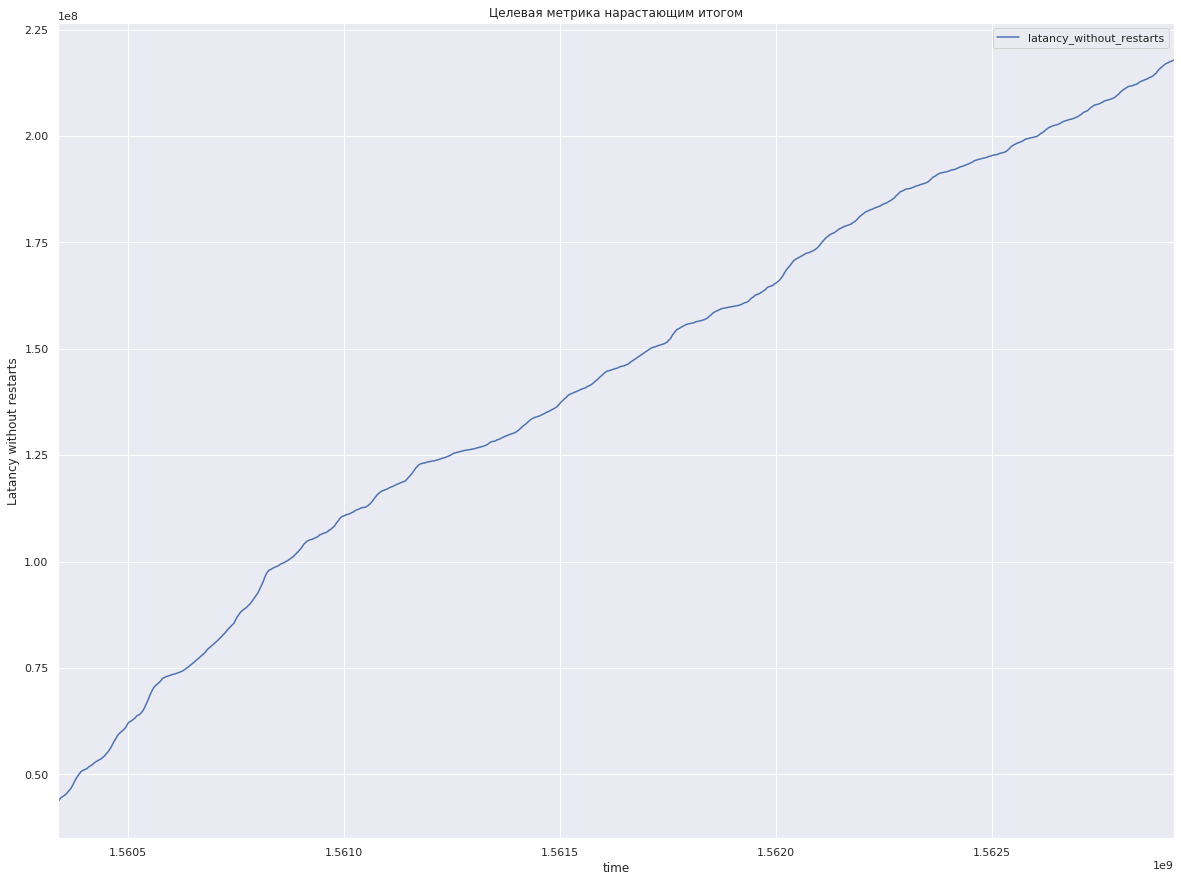

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,1.561712e+09,1.561712e+09,734.0,734.0,28.128021




Начало аномалии: 1561712400.0 
Конец  аномалии: 1561712400.0 


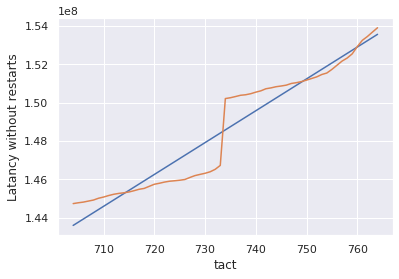

dc = jp2-acs1
['13/06/2019 07:30:00']
abgw_iop_latency_ms_count_dc=jp2-acs1_err=OK_instance=jp2-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=jp2-acs1_err=OK_instance=jp2-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
40,1560411000
92,1560504600
1307,1562743800


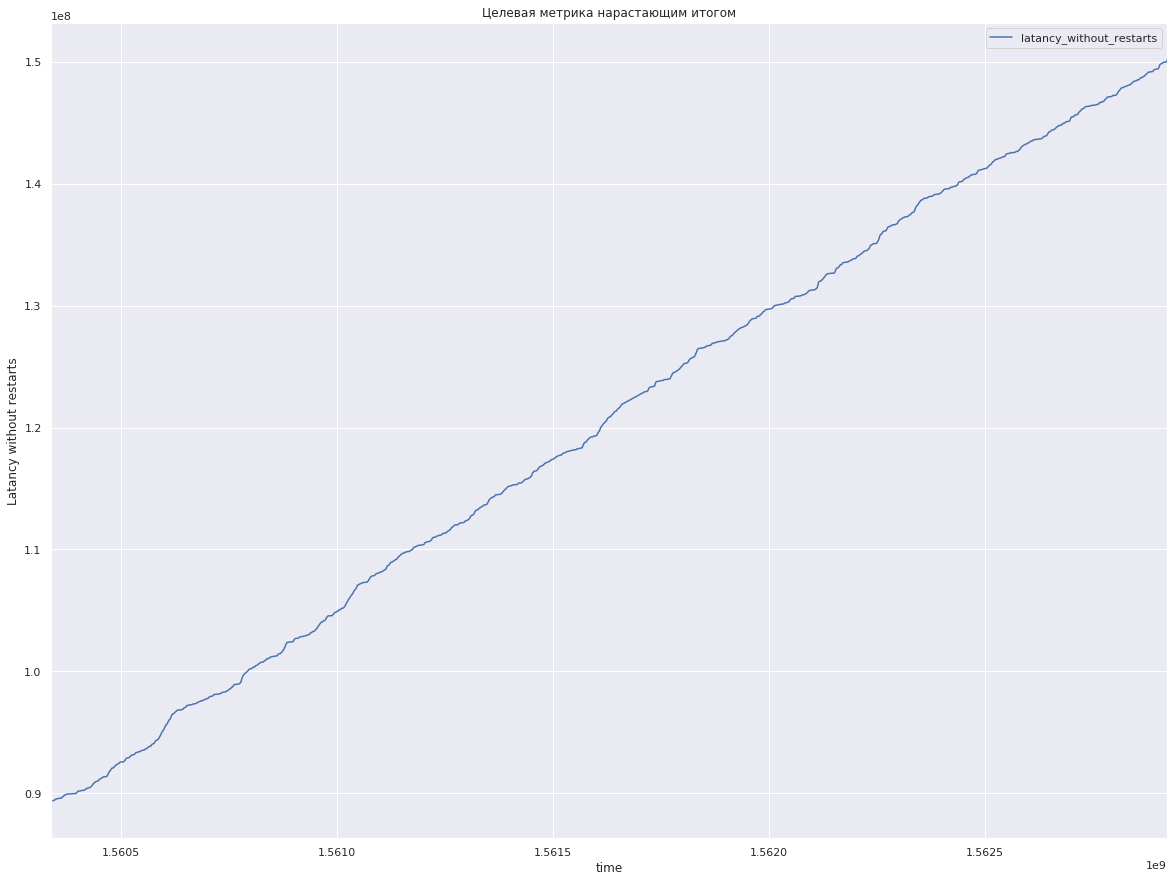

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,1.561712e+09,1.561712e+09,734.0,734.0,22.894328




Начало аномалии: 1561712400.0 
Конец  аномалии: 1561712400.0 


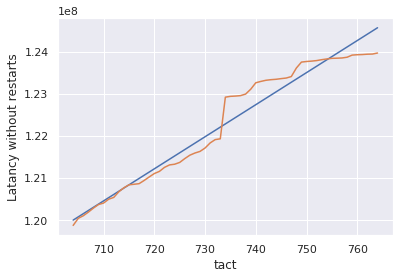

dc = nissan
[]
For some reasons we can't obtain any data
For some reasons we can't obtain any data
For some reasons we can't obtain any data
For some reasons we can't obtain any data
dc = ru2-acs1
[]
abgw_iop_latency_ms_count_dc=ru2-acs1_err=OK_instance=ru2-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=ru2-acs1_err=OK_instance=ru2-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
91,1560502800
371,1561010400




NO DIFF ANOMALY


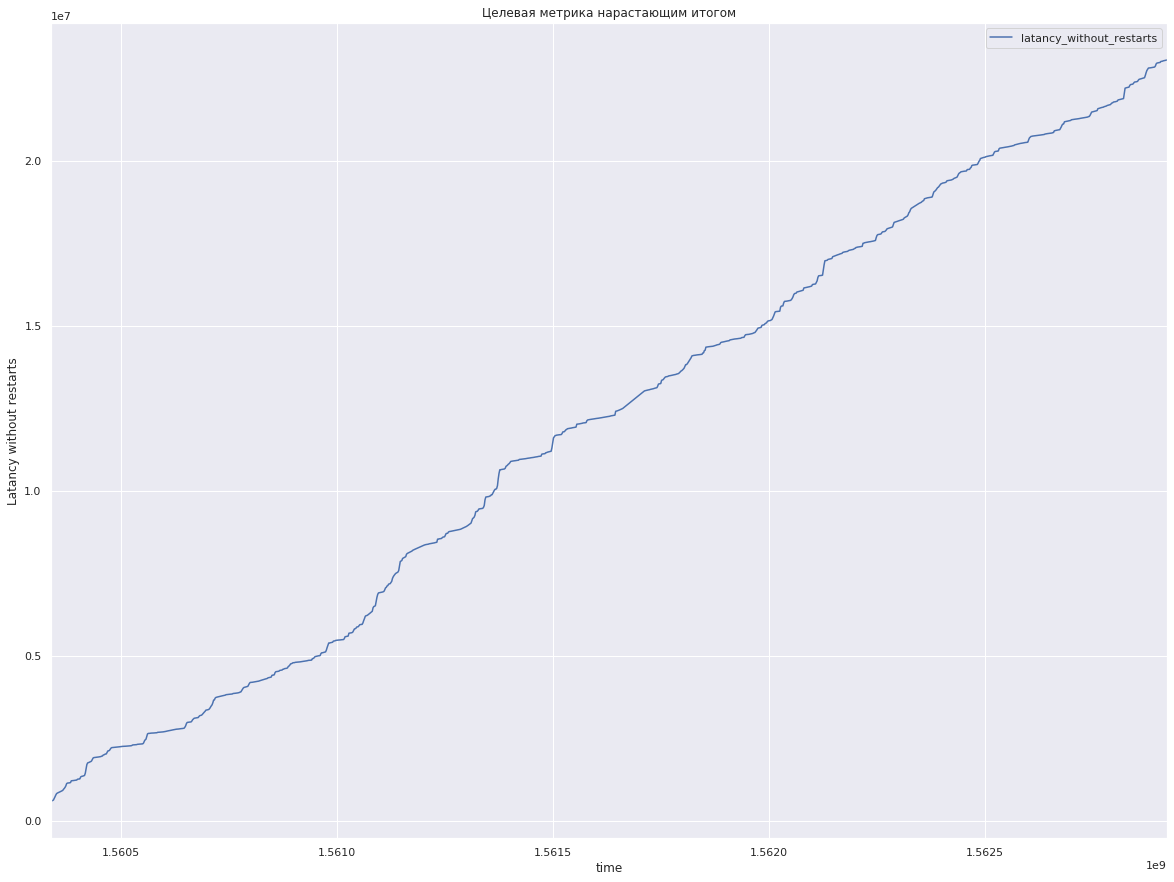

Аномалии:


,time_start,time_end,index_start,index_end,times_more




dc = us2-acs1
[]
abgw_iop_latency_ms_count_dc=us2-acs1_err=OK_instance=us2-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=us2-acs1_err=OK_instance=us2-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
1268,1562677200
1313,1562758200
1325,1562779800




NO DIFF ANOMALY


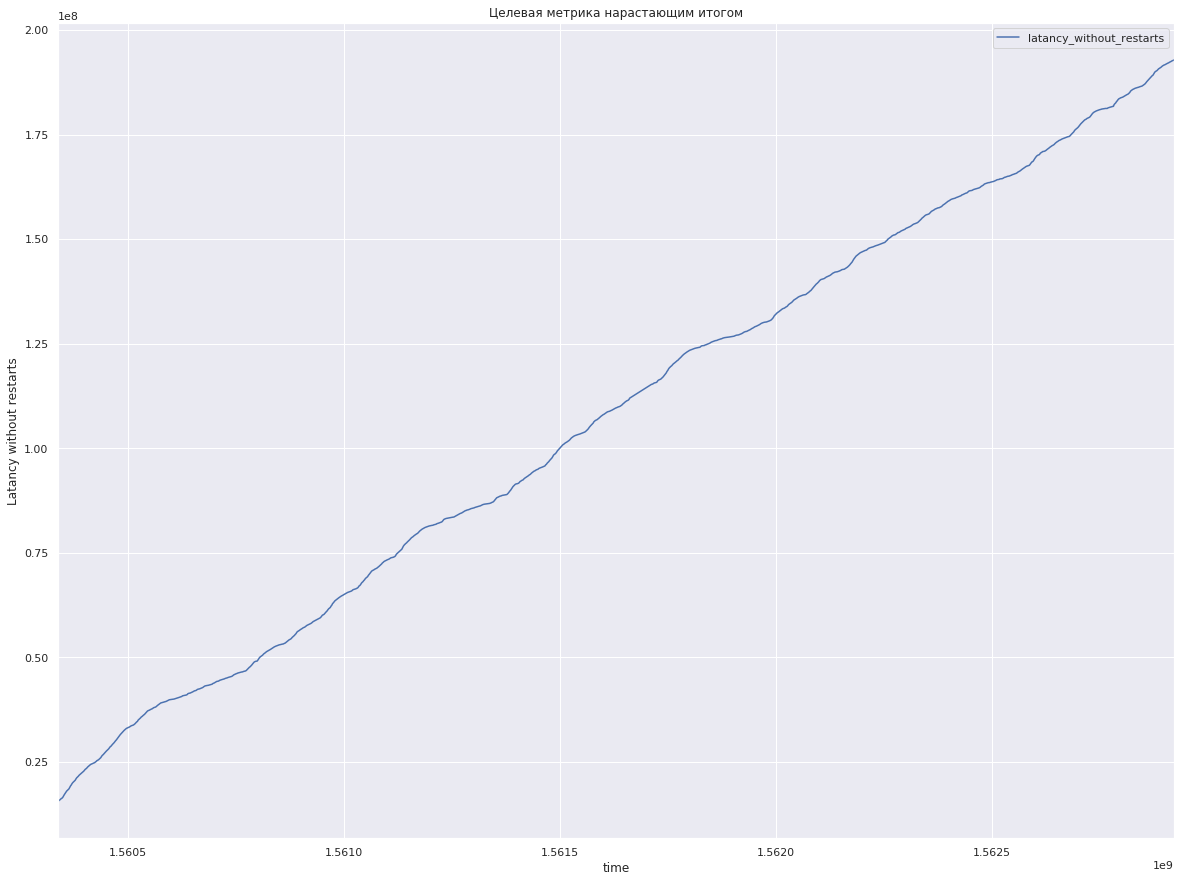

Аномалии:


,time_start,time_end,index_start,index_end,times_more




dc = us3
[]
For some reasons we can't obtain any data
For some reasons we can't obtain any data
For some reasons we can't obtain any data
For some reasons we can't obtain any data
dc = us3-acs2
[]
abgw_iop_latency_ms_count_dc=us3-acs2_err=OK_instance=us3-acs2-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=us3-acs2_err=OK_instance=us3-acs2-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
565,1561359600
1074,1562324400
1260,1562666400


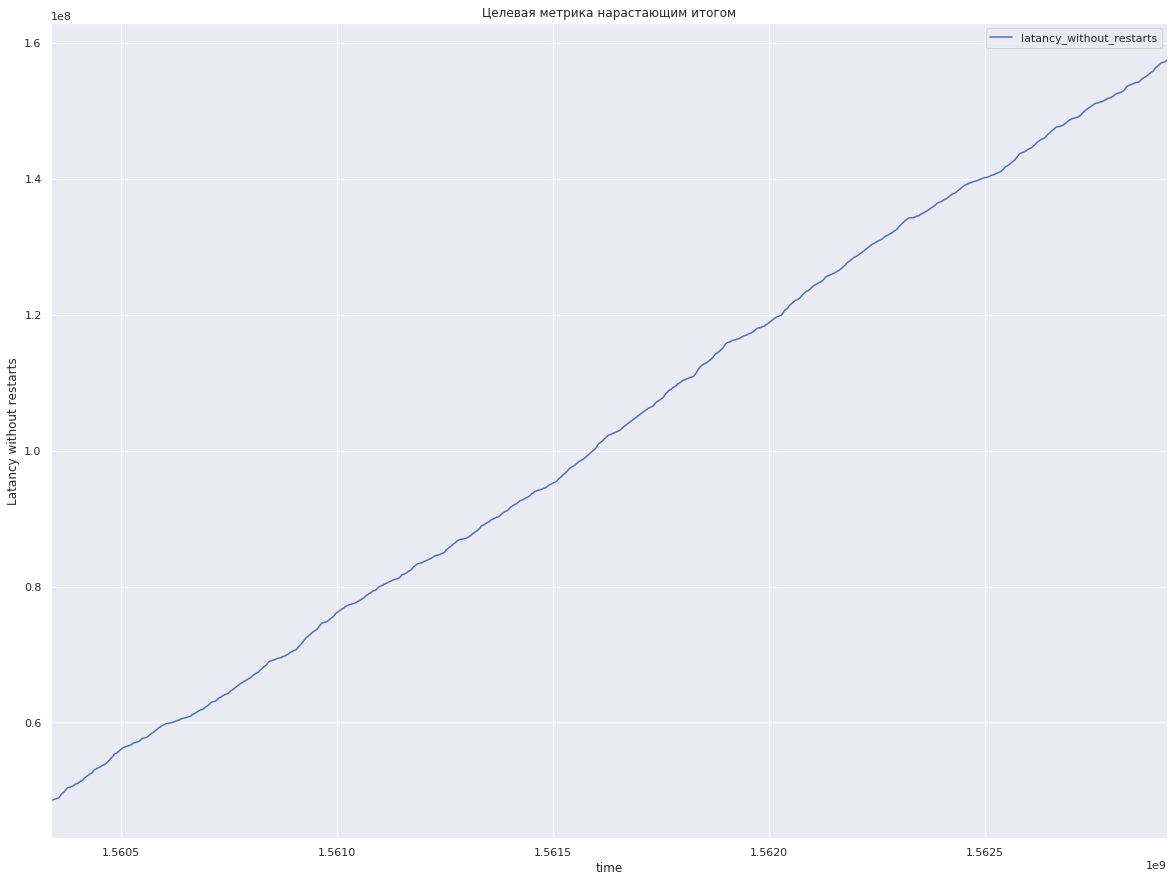

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,1.561712e+09,1.561712e+09,734.0,734.0,31.161609




Начало аномалии: 1561712400.0 
Конец  аномалии: 1561712400.0 


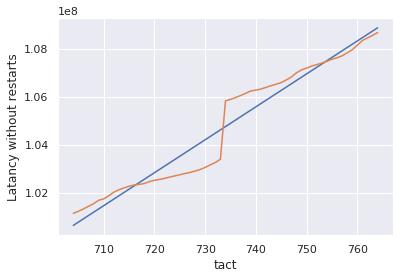

dc = us6-acs1
[]
abgw_iop_latency_ms_count_dc=us6-acs1_err=OK_instance=us6-acs1-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=us6-acs1_err=OK_instance=us6-acs1-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
929,1562063400




NO DIFF ANOMALY


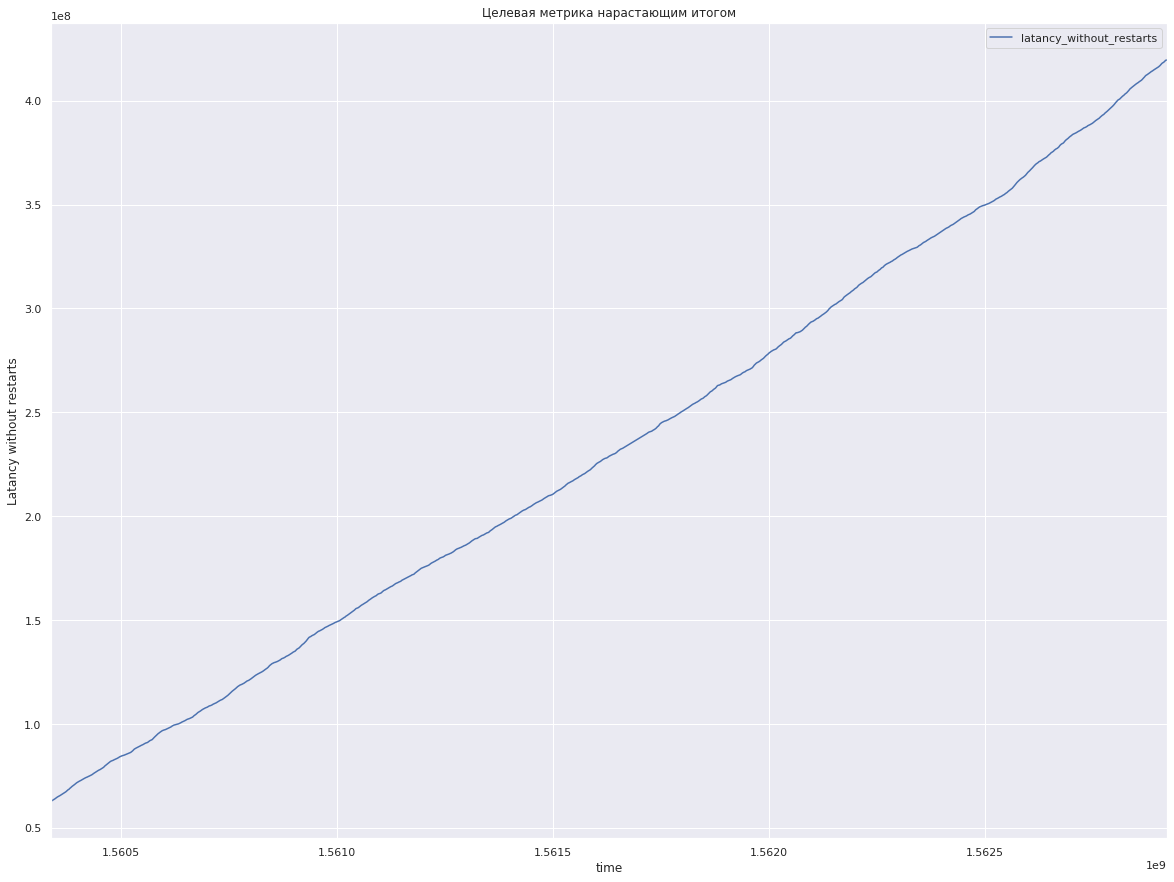

Аномалии:


,time_start,time_end,index_start,index_end,times_more




dc = us6-acs2
[]
abgw_iop_latency_ms_count_dc=us6-acs2_err=OK_instance=us6-acs2-stor01.vstoragedomain_iop=isync_proxied=0


Метрика: abgw_iop_latency_ms_count_dc=us6-acs2_err=OK_instance=us6-acs2-stor01.vstoragedomain_iop=isync_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
889,1561991400
1018,1562223600
1223,1562592600
1317,1562761800


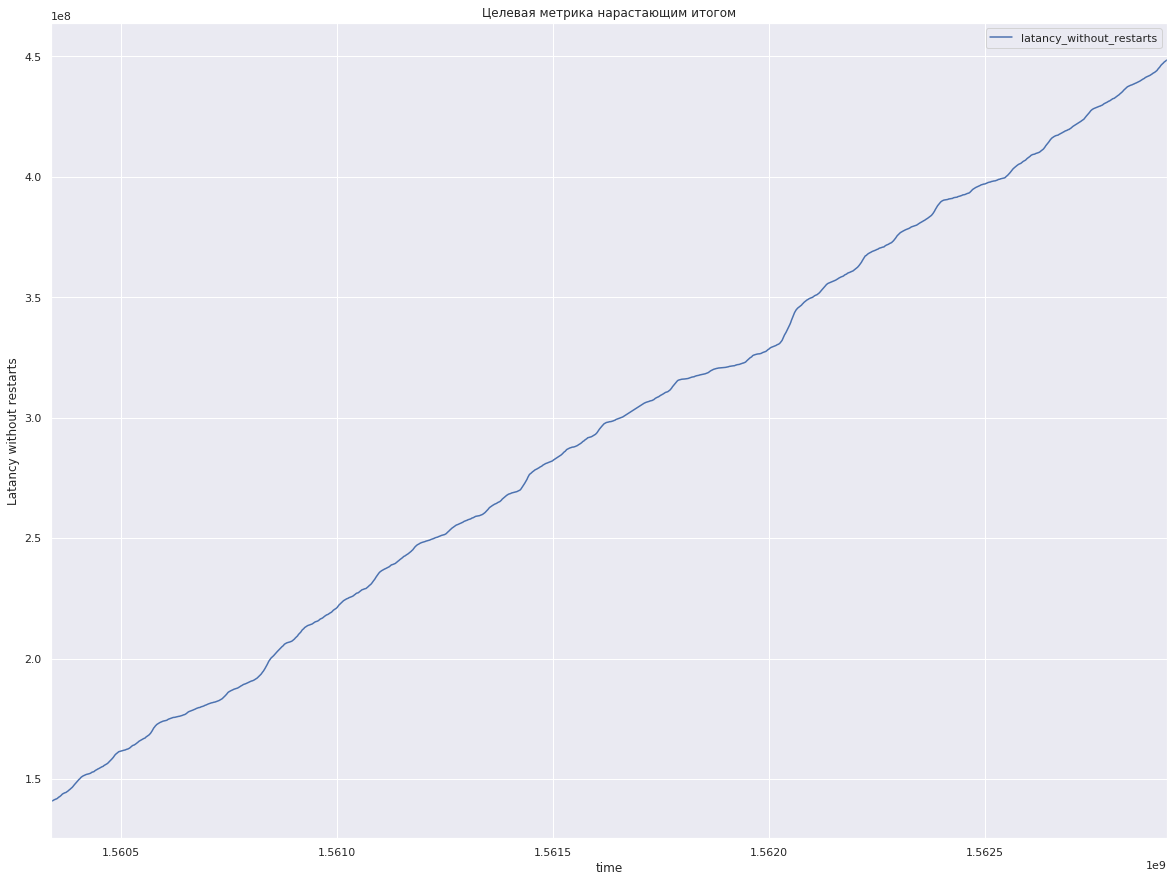

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,1.561712e+09,1.561712e+09,734.0,734.0,26.490971




Начало аномалии: 1561712400.0 
Конец  аномалии: 1561712400.0 


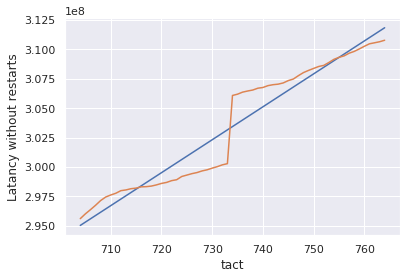

In [201]:
df_info = {}
df_info['step'] = '30m'
df_info['START_TIME'] = '12/06/2019 12:00'
df_info['END_TIME'] = '12/07/2019 12:31'
df_info['dcs'] = dcs
df_info['upd_features'] = upd_features
df_info['querys'] = querys
anomaly_result(df_info,'abgw_iop_latency_ms_count_err',
                       nums, 1)

# Отчет

Далее демонстрируется сводка по данным из файлов csv, первый аргумент это их имена, второй - метрика, 3 аргумент (имеет туже размерность что и перый, это число, свое для каждого сервера, показывающее во сколько раз производная превосходит среднее значиение, чтобы считаться аномалией. И наконец 4 аргумент принимает значения 0 и 1. В случае 0 информация по каждому серверу скупа, в случае 1 - развернута(с графиками). Общая сводка в конце.

dc = au2-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
2527,03_06_13:06


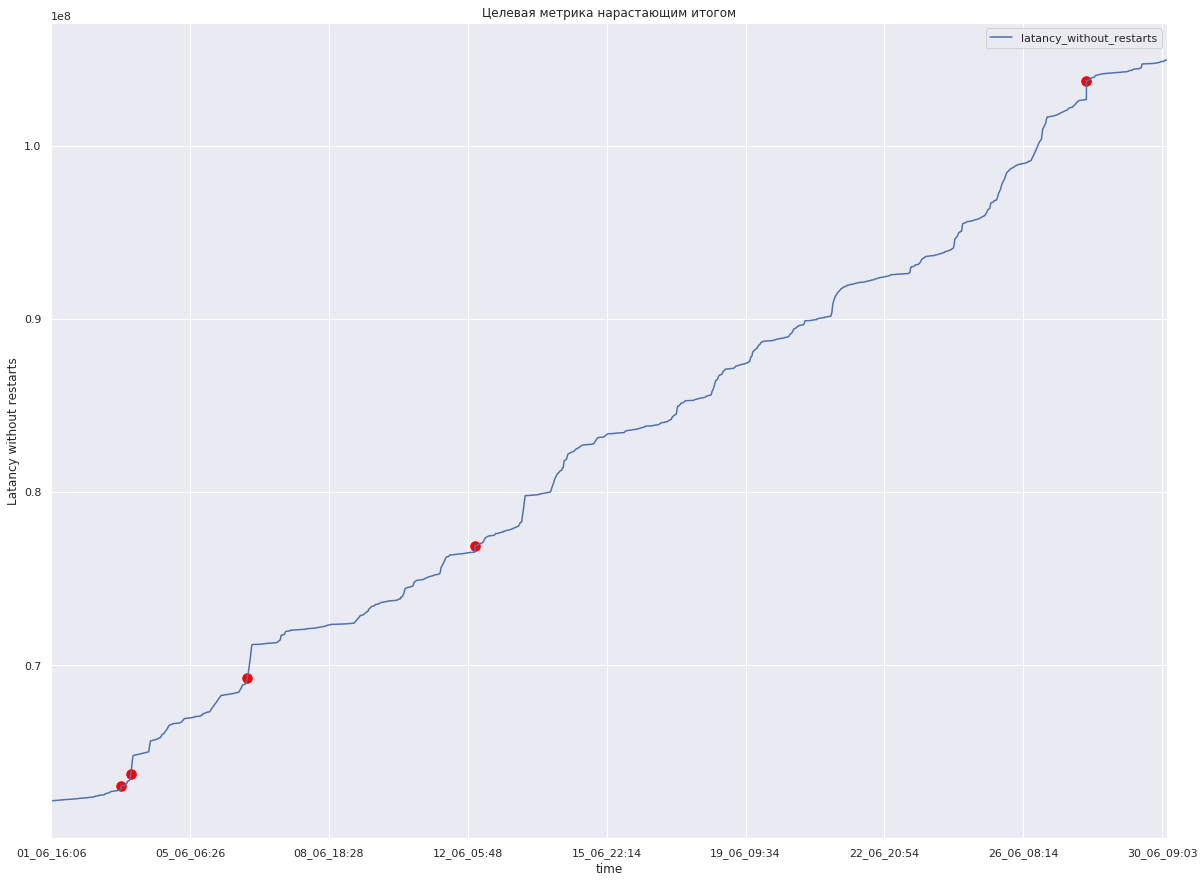

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,03_06_12:58,03_06_12:58,2519,2519,135.886022
1,03_06_18:43,03_06_18:43,2863,2863,63.432618
2,06_06_17:26,06_06_17:26,7058,7058,103.543869
3,12_06_14:11,12_06_14:11,15256,15256,312.206069
4,28_06_11:36,28_06_11:36,37273,37273,1026.693763




Начало аномалии: 03_06_12:58 
Конец  аномалии: 03_06_12:58 


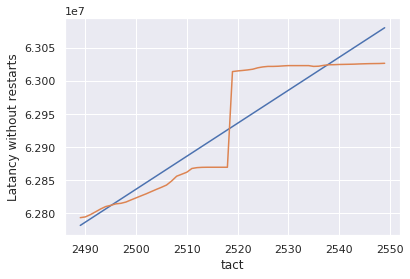

Начало аномалии: 03_06_18:43 
Конец  аномалии: 03_06_18:43 


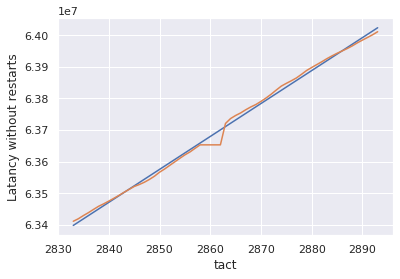

Начало аномалии: 06_06_17:26 
Конец  аномалии: 06_06_17:26 


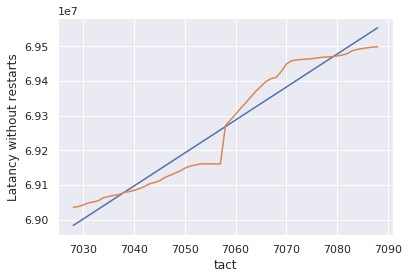

Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


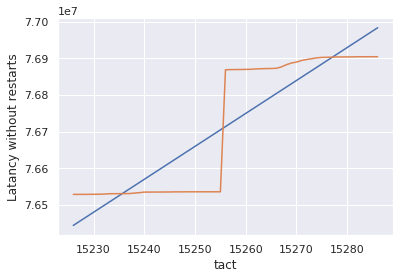

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


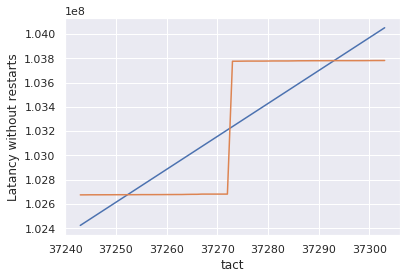

dc = eu2-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участки отсутсвия данных:


,time_start,time_end,index_start,index_end
0,17_06_04:47,17_06_07:24,22049,22206
1,18_06_17:26,23_06_01:04,24232,30450
2,28_06_14:32,30_06_12:00,37649,40377




Моменты перезагрузки сервера:


,time
2843,03_06_15:29
5747,05_06_15:59
22048,17_06_04:46
24045,18_06_16:46
24073,18_06_17:14


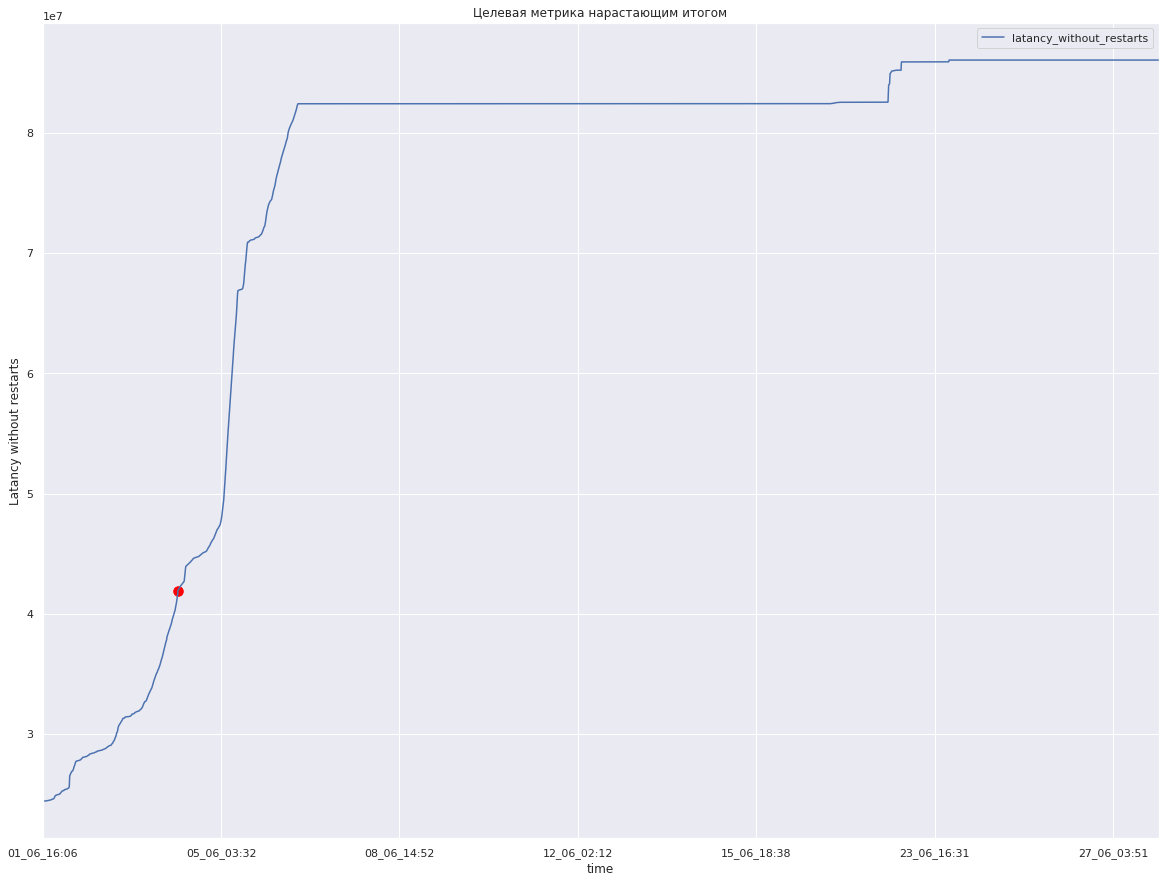

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,04_06_07:23,04_06_07:23,3791,3791,127.960019




Начало аномалии: 04_06_07:23 
Конец  аномалии: 04_06_07:23 


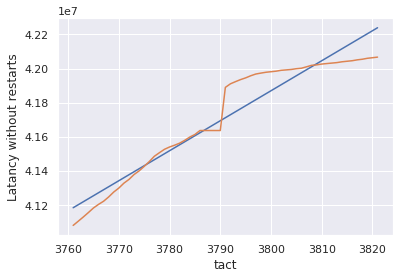

dc = eu3-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Перезагрузок сервера не было.




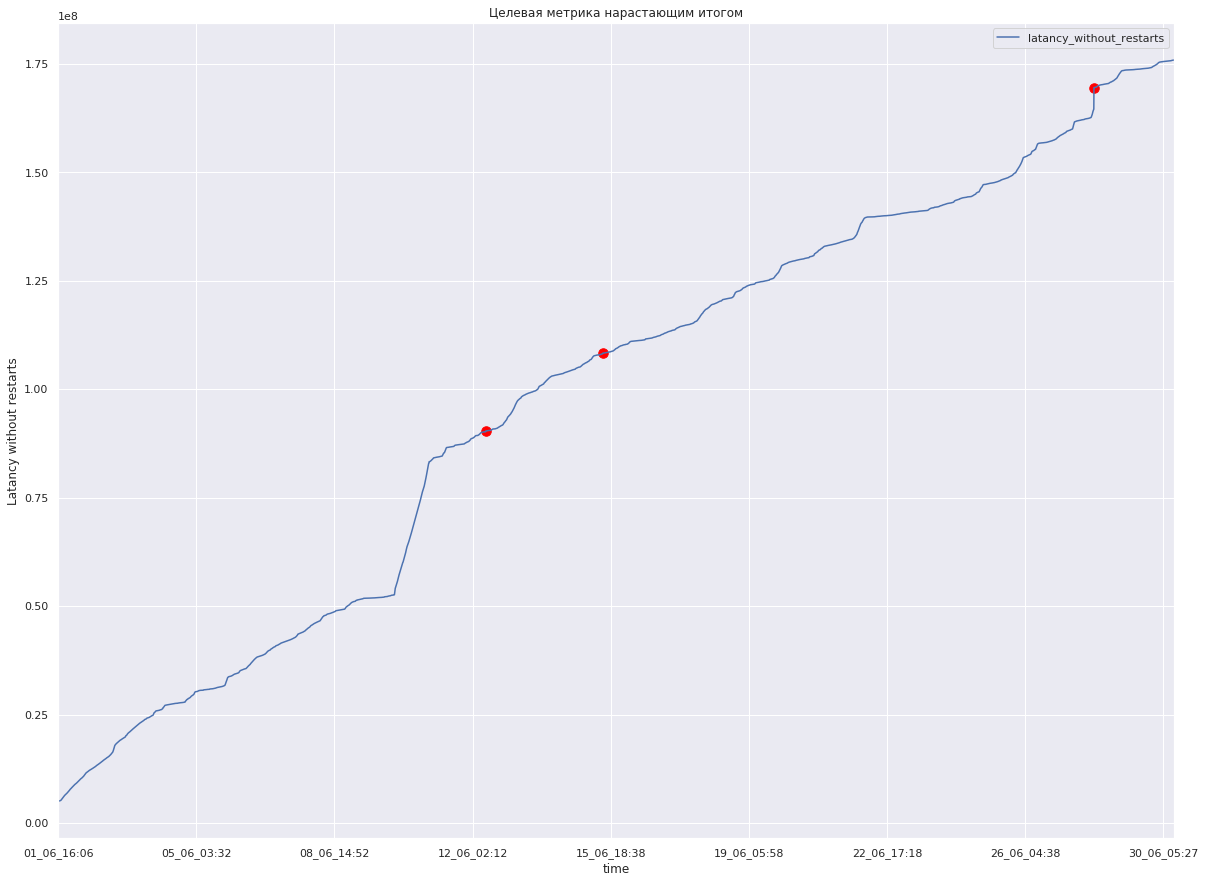

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,15473,15473,41.280041
1,15_06_13:45,15_06_13:45,19707,19707,29.469197
2,28_06_11:36,28_06_11:36,37489,37489,1185.726633




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


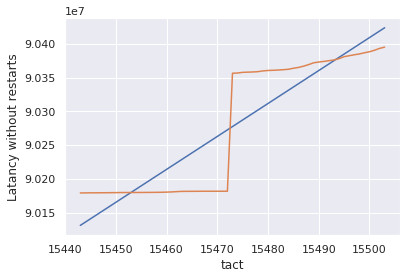

Начало аномалии: 15_06_13:45 
Конец  аномалии: 15_06_13:45 


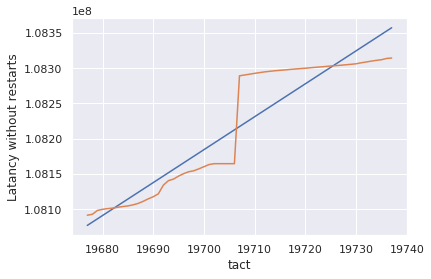

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


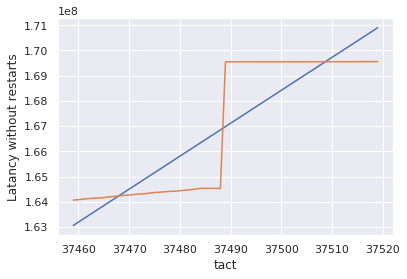

dc = eu5-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
8287,07_06_10:43


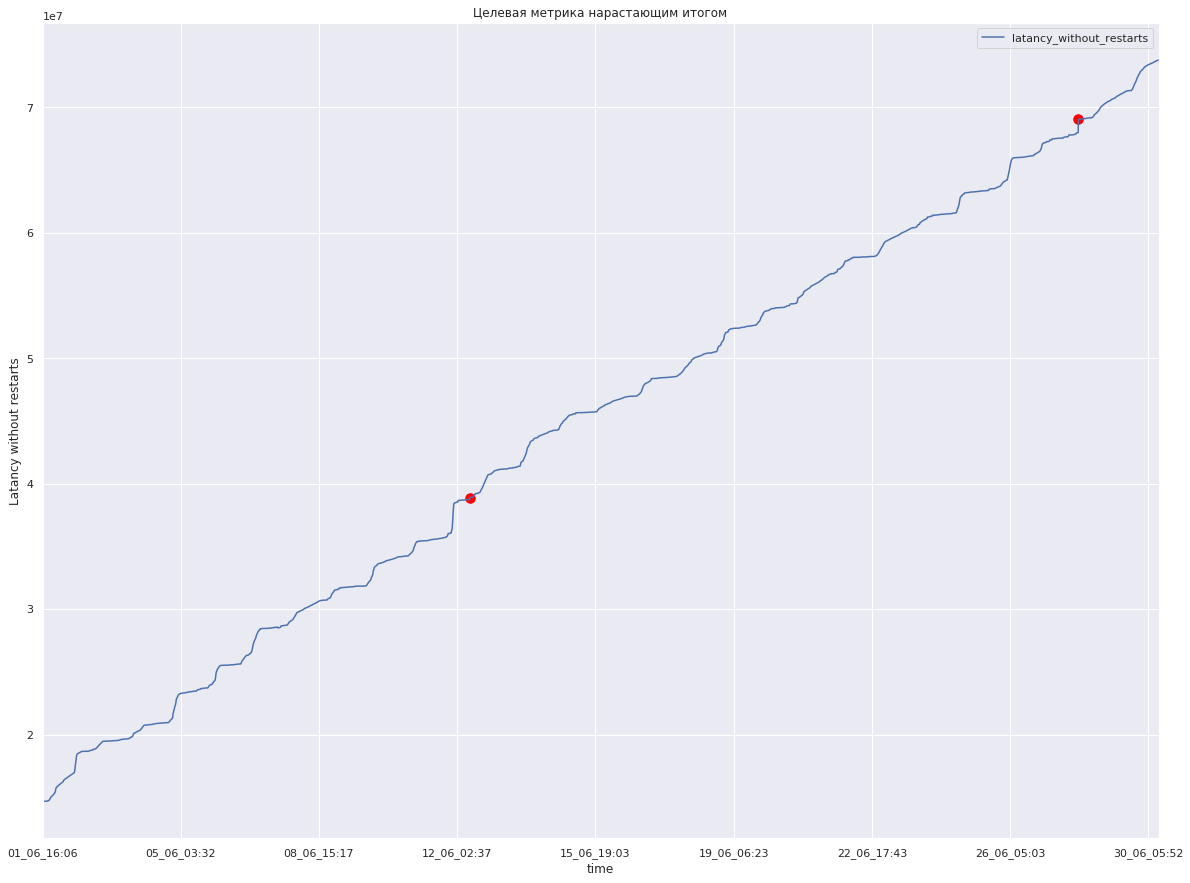

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,15448,15448,103.069653
1,28_06_11:36,28_06_11:36,37464,37464,711.689895




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


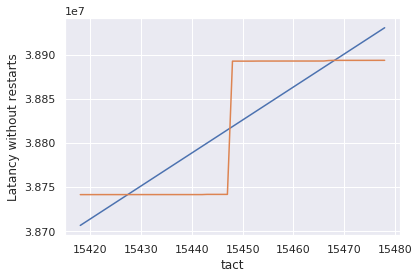

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


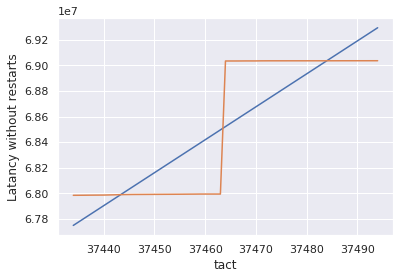

dc = eu9-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участки отсутсвия данных:


,time_start,time_end,index_start,index_end
0,01_06_16:06,06_06_16:05,0,7178




Моменты перезагрузки сервера:


,time
1363,07_06_14:49
8302,12_06_14:34
20013,20_06_18:46
22731,22_06_16:04


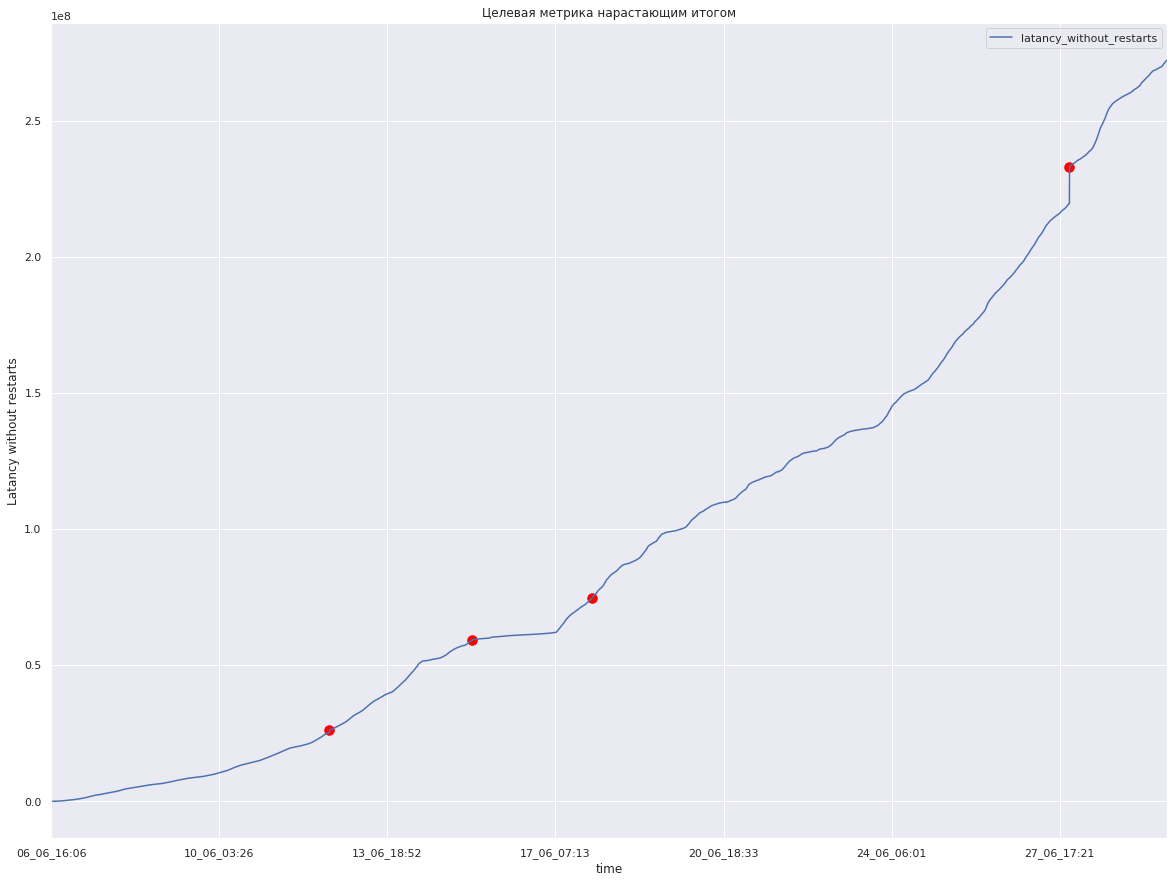

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,8279,8279,114.109528
1,15_06_13:45,15_06_13:45,12512,12512,36.500143
2,18_06_01:17,18_06_01:17,16084,16084,7.088876
3,28_06_11:36,28_06_11:36,30286,30286,1648.125251




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


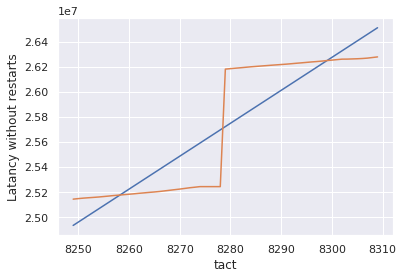

Начало аномалии: 15_06_13:45 
Конец  аномалии: 15_06_13:45 


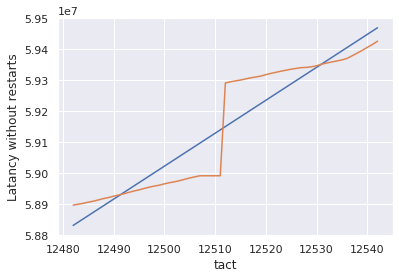

Начало аномалии: 18_06_01:17 
Конец  аномалии: 18_06_01:17 


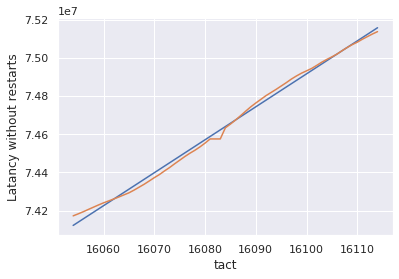

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


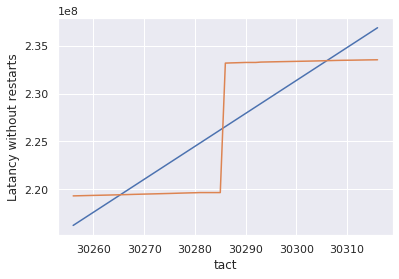

dc = jp2-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
16698,13_06_10:38
18276,14_06_12:58


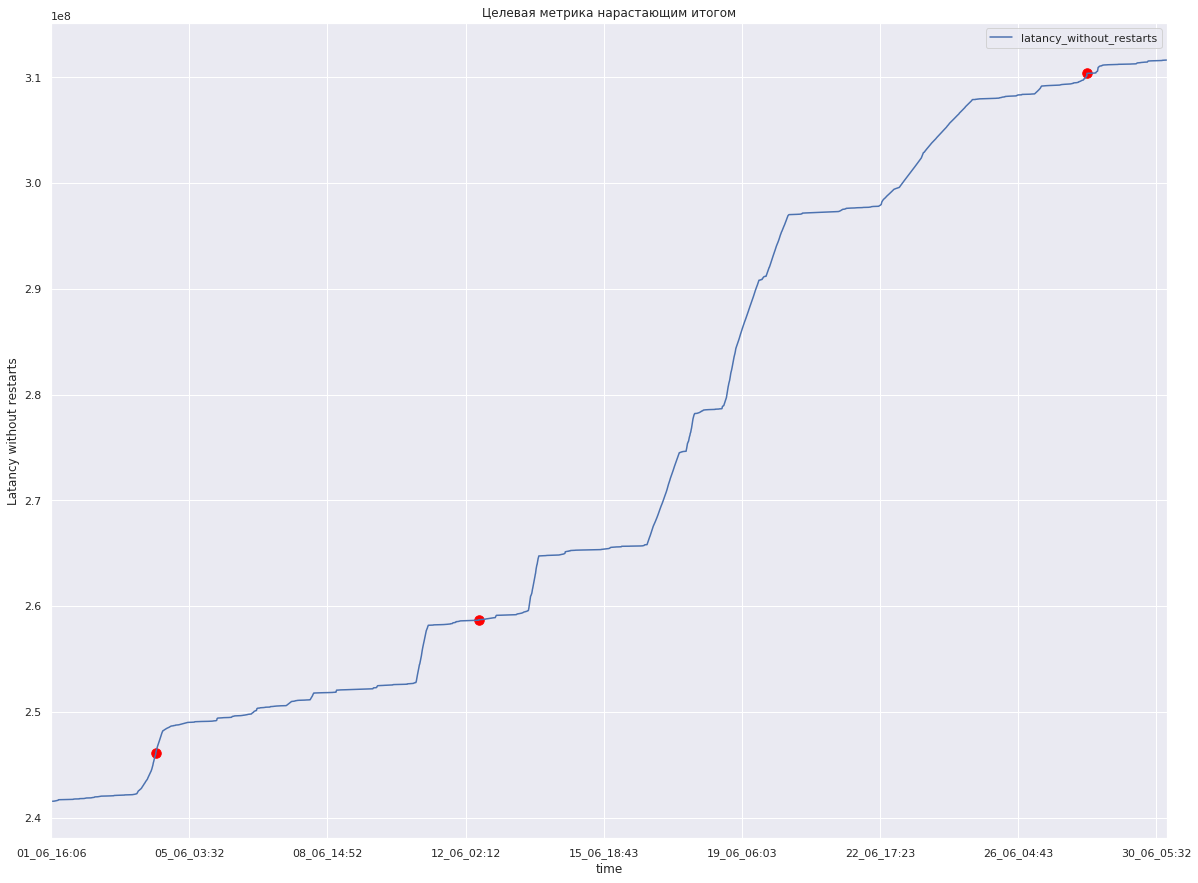

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,04_06_07:22,04_06_07:22,3790,3790,53.223361
1,12_06_14:10,12_06_14:10,15472,15472,27.847269
2,28_06_11:36,28_06_11:36,37484,37484,140.037218




Начало аномалии: 04_06_07:22 
Конец  аномалии: 04_06_07:22 


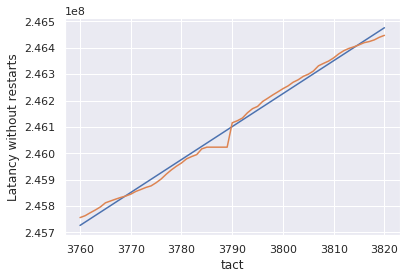

Начало аномалии: 12_06_14:10 
Конец  аномалии: 12_06_14:10 


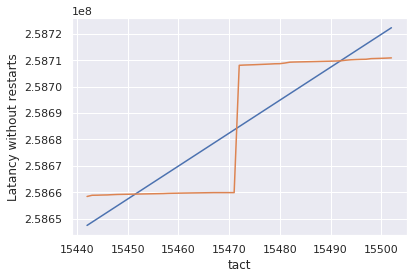

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


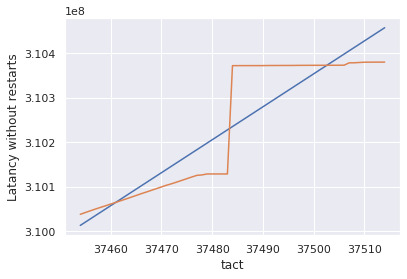

dc = nissan
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Перезагрузок сервера не было.




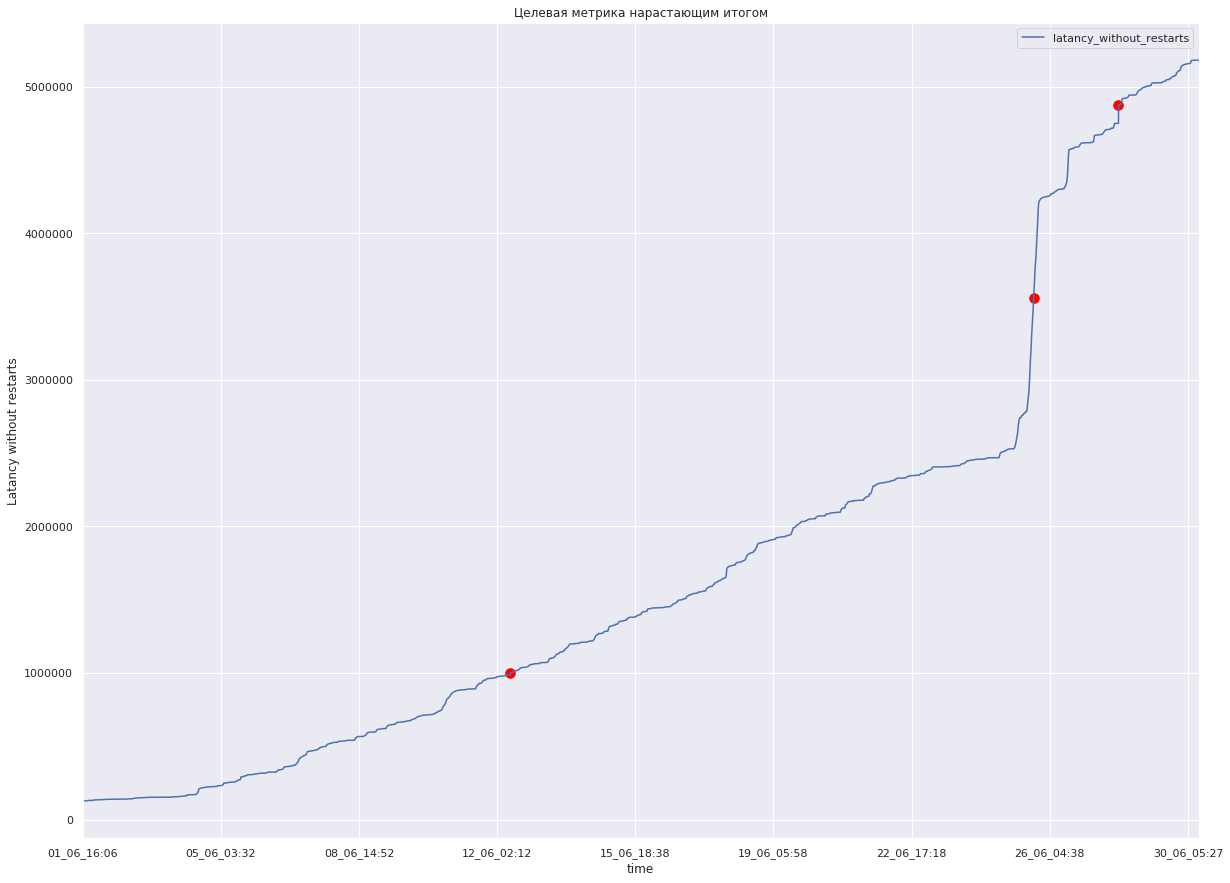

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,15473,15473,106.318092
1,25_06_18:56,25_06_18:57,34418,34419,78.876012
2,28_06_11:37,28_06_11:37,37490,37490,995.582034




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


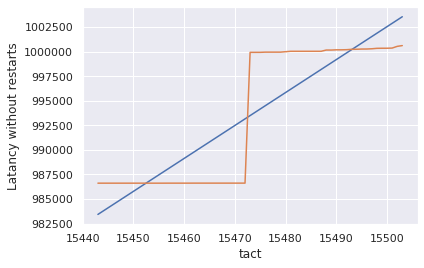

Начало аномалии: 25_06_18:56 
Конец  аномалии: 25_06_18:57 


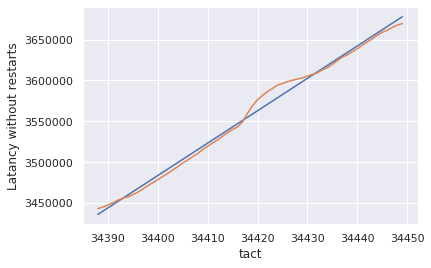

Начало аномалии: 28_06_11:37 
Конец  аномалии: 28_06_11:37 


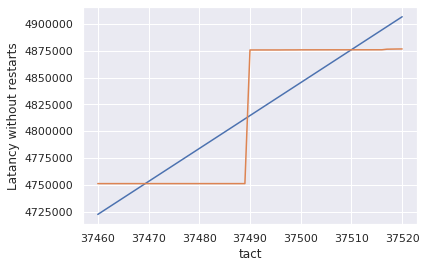

dc = ru2-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участки отсутсвия данных:


,time_start,time_end,index_start,index_end
0,11_06_10:59,11_06_11:05,13992,13998
1,20_06_09:07,20_06_09:10,26535,26538




Моменты перезагрузки сервера:


,time
13991,11_06_09:22
18122,14_06_12:02
26527,20_06_09:06


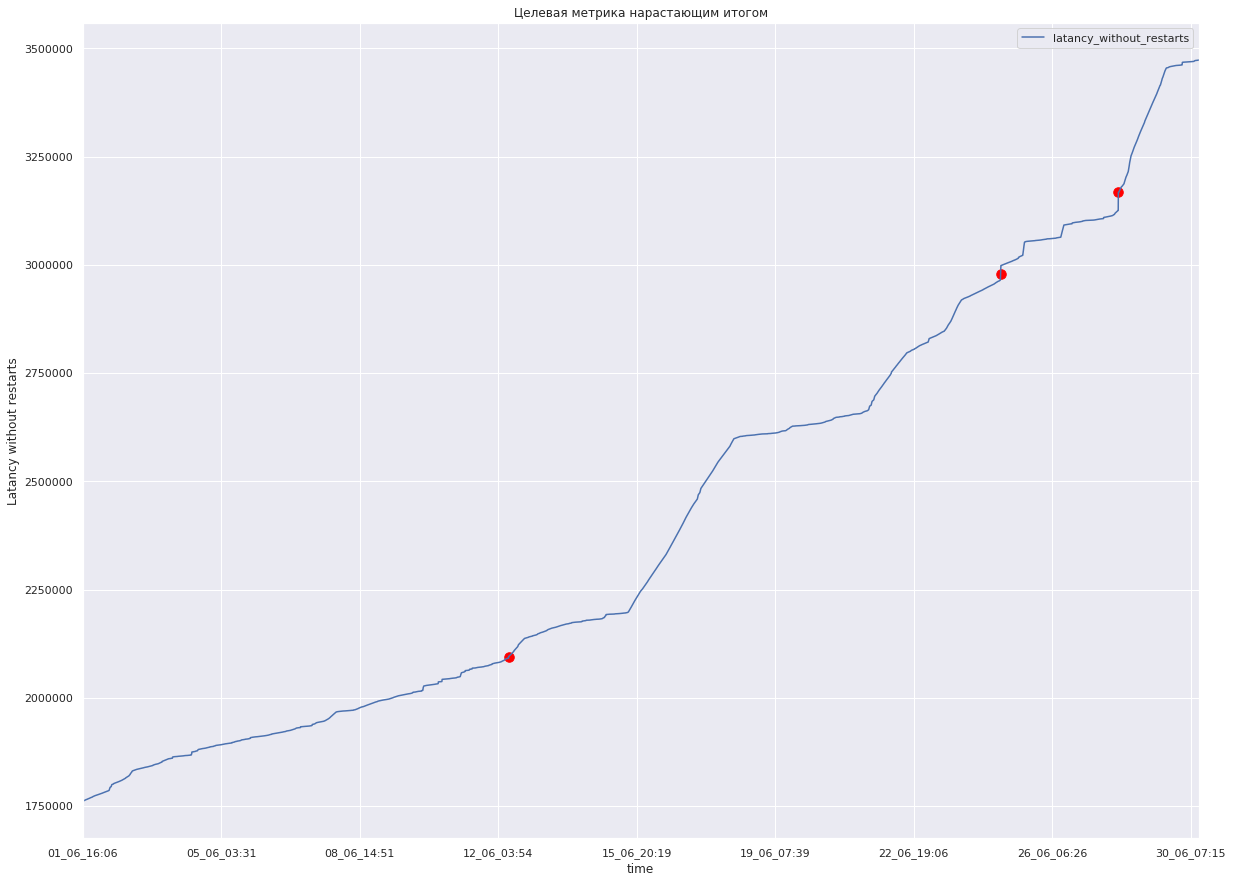

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,15371,15371,89.381370
1,24_06_23:19,24_06_23:19,33133,33133,60.089502
2,28_06_11:36,28_06_11:36,37381,37381,987.335932




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


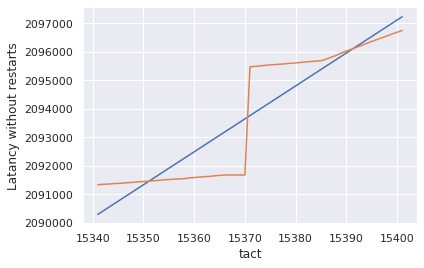

Начало аномалии: 24_06_23:19 
Конец  аномалии: 24_06_23:19 


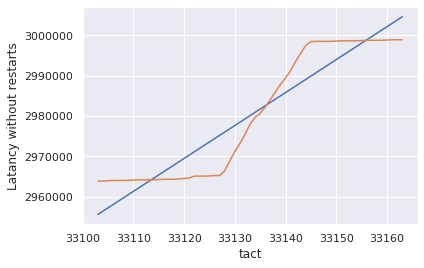

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


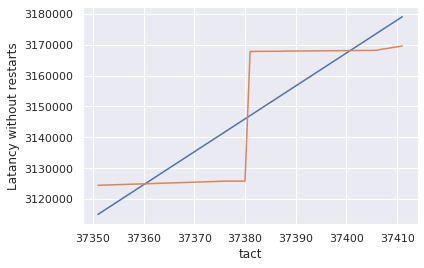

dc = us2-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участки отсутсвия данных:


,time_start,time_end,index_start,index_end
0,10_06_11:54,10_06_11:54,12567,12567




Моменты перезагрузки сервера:


,time
7215,06_06_18:40
12558,10_06_11:43


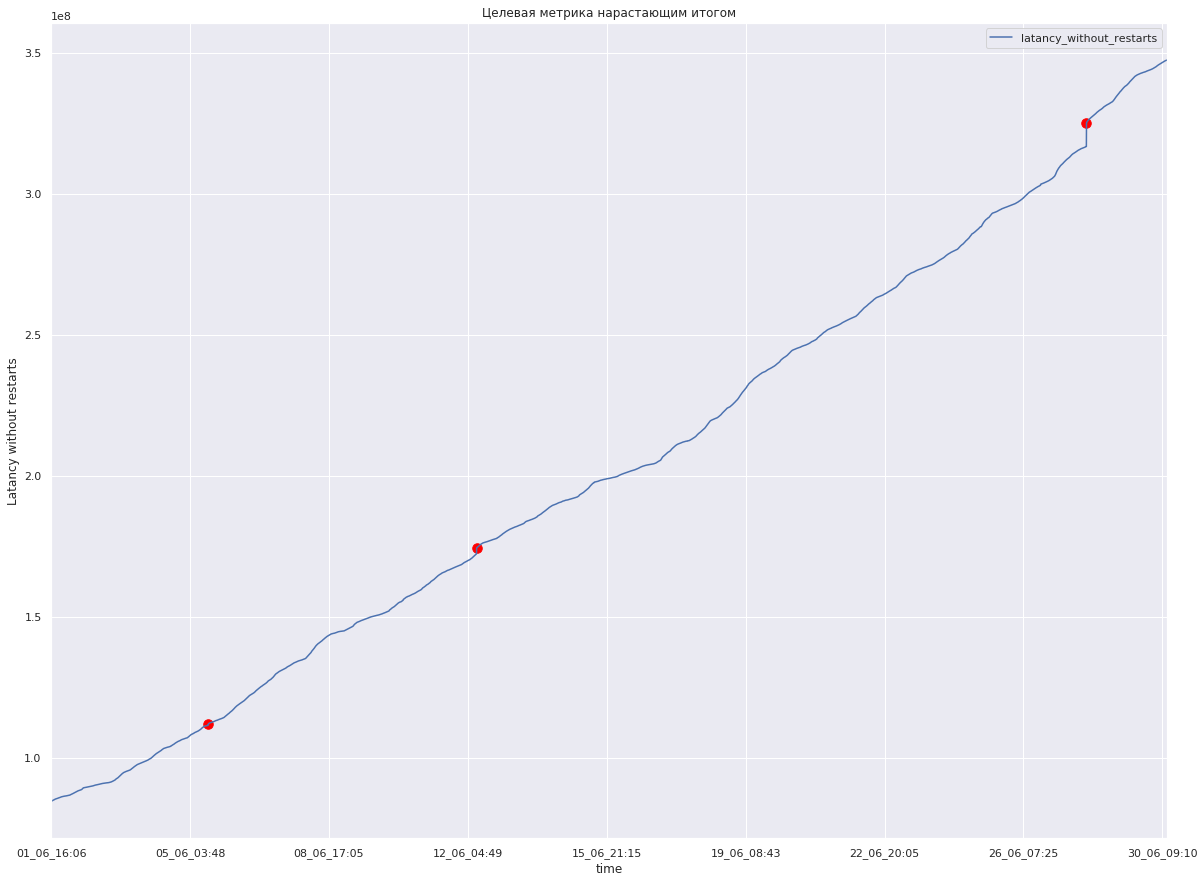

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,05_06_15:59,05_06_15:59,5651,5651,65.429908
1,12_06_14:11,12_06_14:11,15315,15315,323.209589
2,28_06_11:36,28_06_11:36,37266,37266,1276.264892




Начало аномалии: 05_06_15:59 
Конец  аномалии: 05_06_15:59 


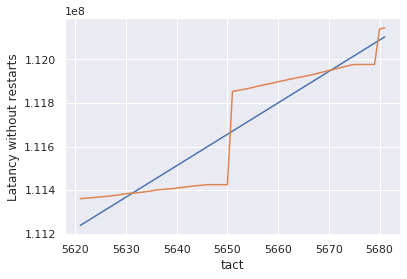

Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


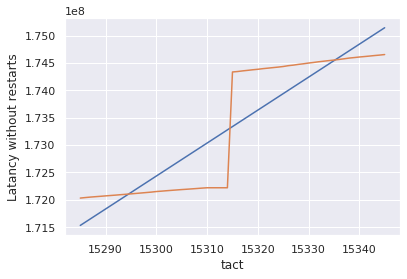

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


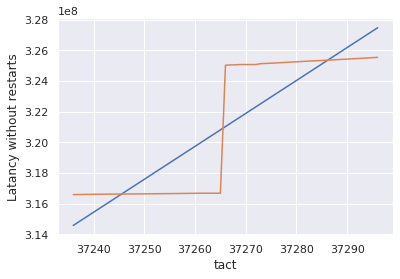

dc = us3
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участки отсутсвия данных:


,time_start,time_end,index_start,index_end
0,19_06_15:44,19_06_15:44,25543,25543




Моменты перезагрузки сервера:


,time
4263,04_06_15:15
25542,19_06_15:07


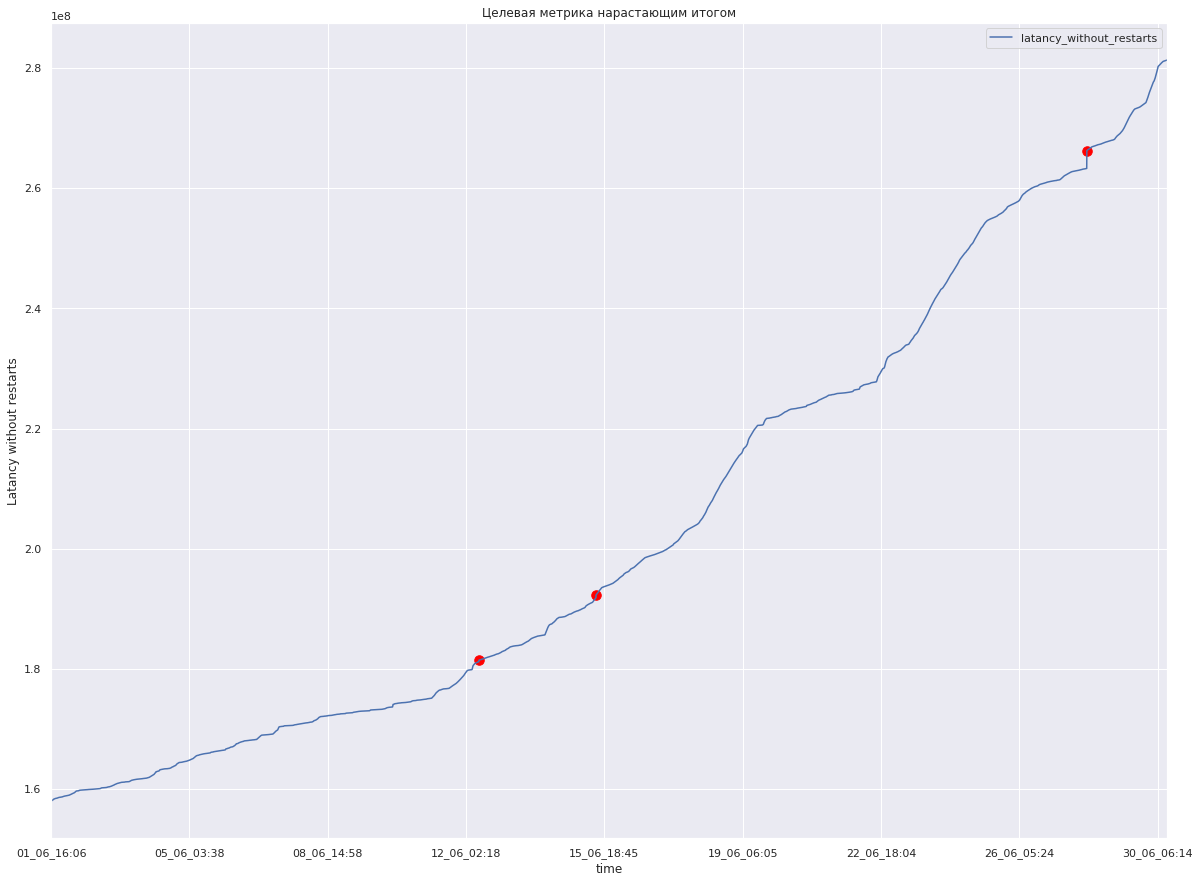

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,15466,15466,85.657550
1,15_06_13:44,15_06_13:44,19699,19699,143.478481
2,28_06_11:36,28_06_11:36,37442,37442,970.785021




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


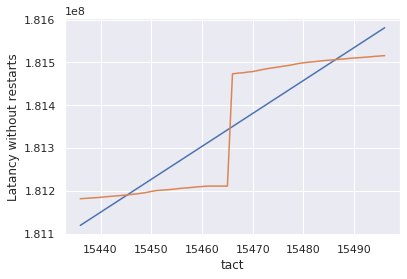

Начало аномалии: 15_06_13:44 
Конец  аномалии: 15_06_13:44 


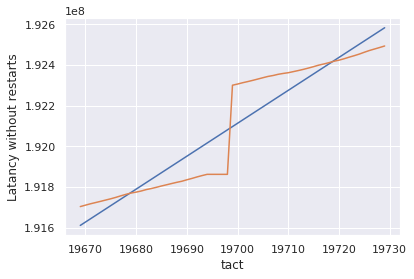

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


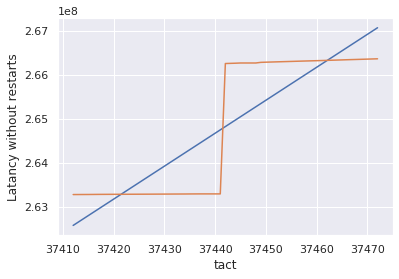

dc = us3-acs2
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
32464,24_06_10:26


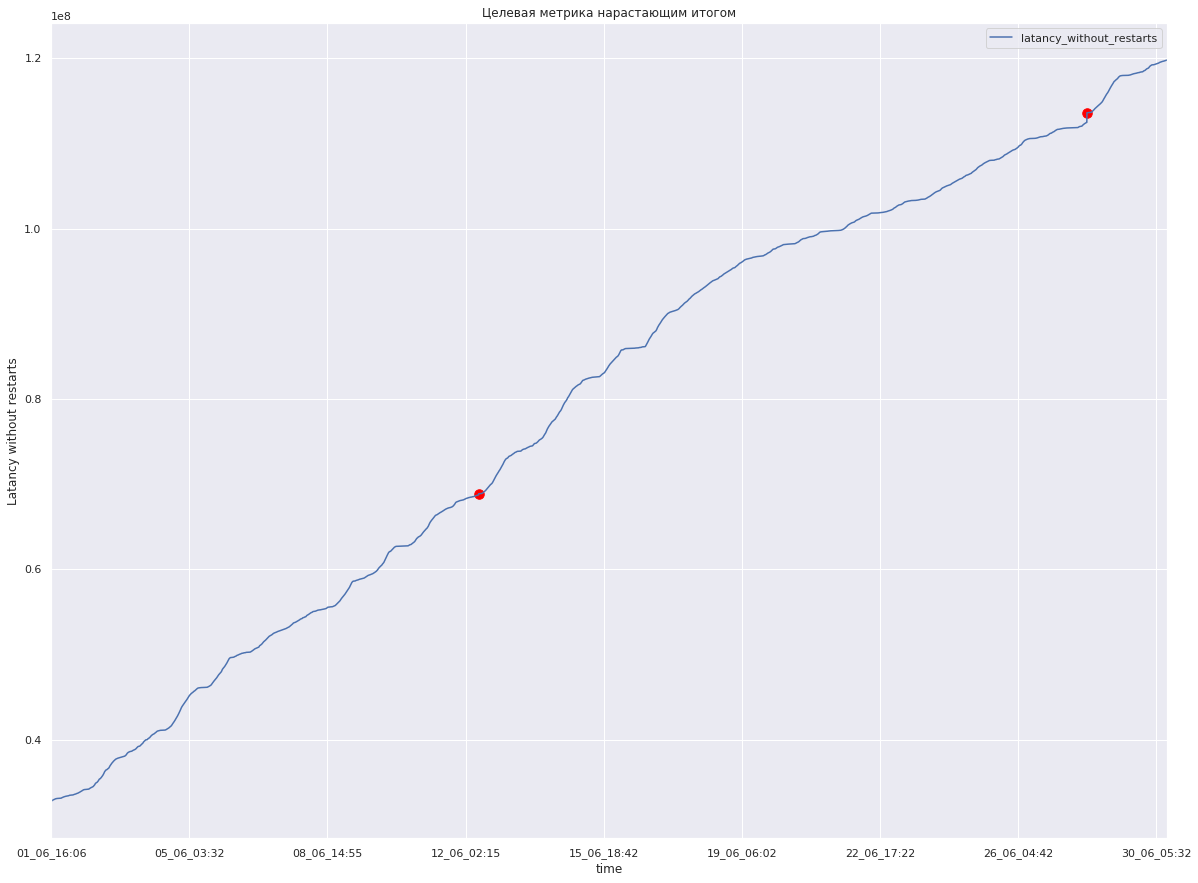

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:12,12_06_14:12,15470,15470,59.165283
1,28_06_11:37,28_06_11:37,37485,37485,526.208796




Начало аномалии: 12_06_14:12 
Конец  аномалии: 12_06_14:12 


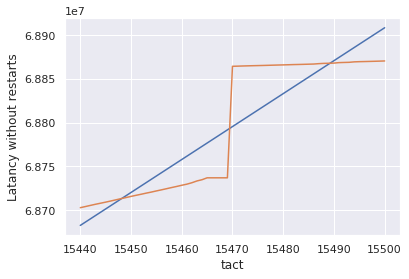

Начало аномалии: 28_06_11:37 
Конец  аномалии: 28_06_11:37 


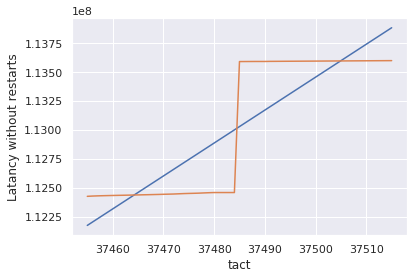

dc = us6-acs1
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
7007,06_06_13:03


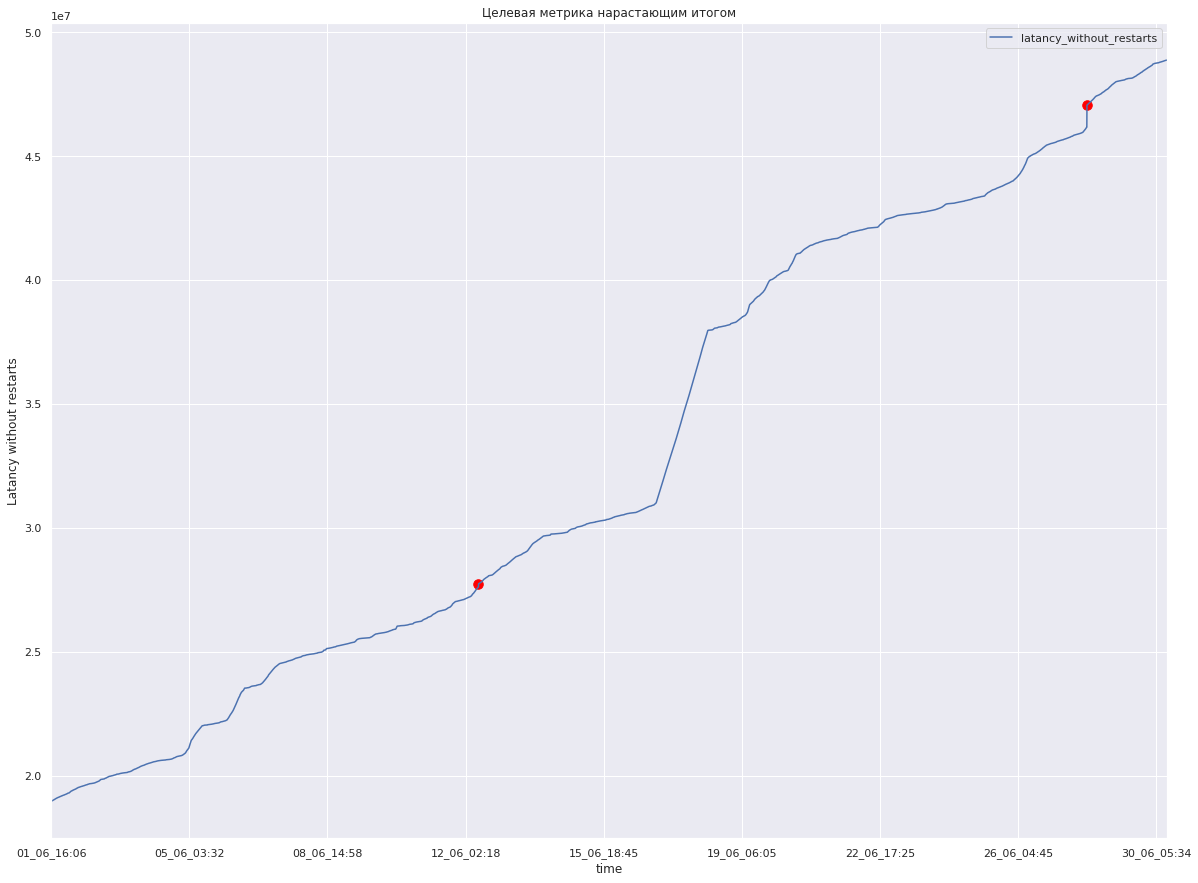

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:12,12_06_14:12,15467,15467,177.635197
1,28_06_11:37,28_06_11:37,37483,37483,1191.622216




Начало аномалии: 12_06_14:12 
Конец  аномалии: 12_06_14:12 


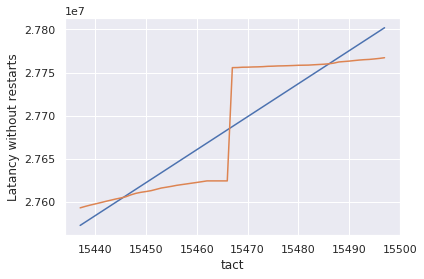

Начало аномалии: 28_06_11:37 
Конец  аномалии: 28_06_11:37 


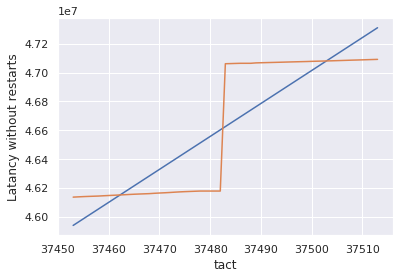

dc = us6-acs2
abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Перезагрузок сервера не было.




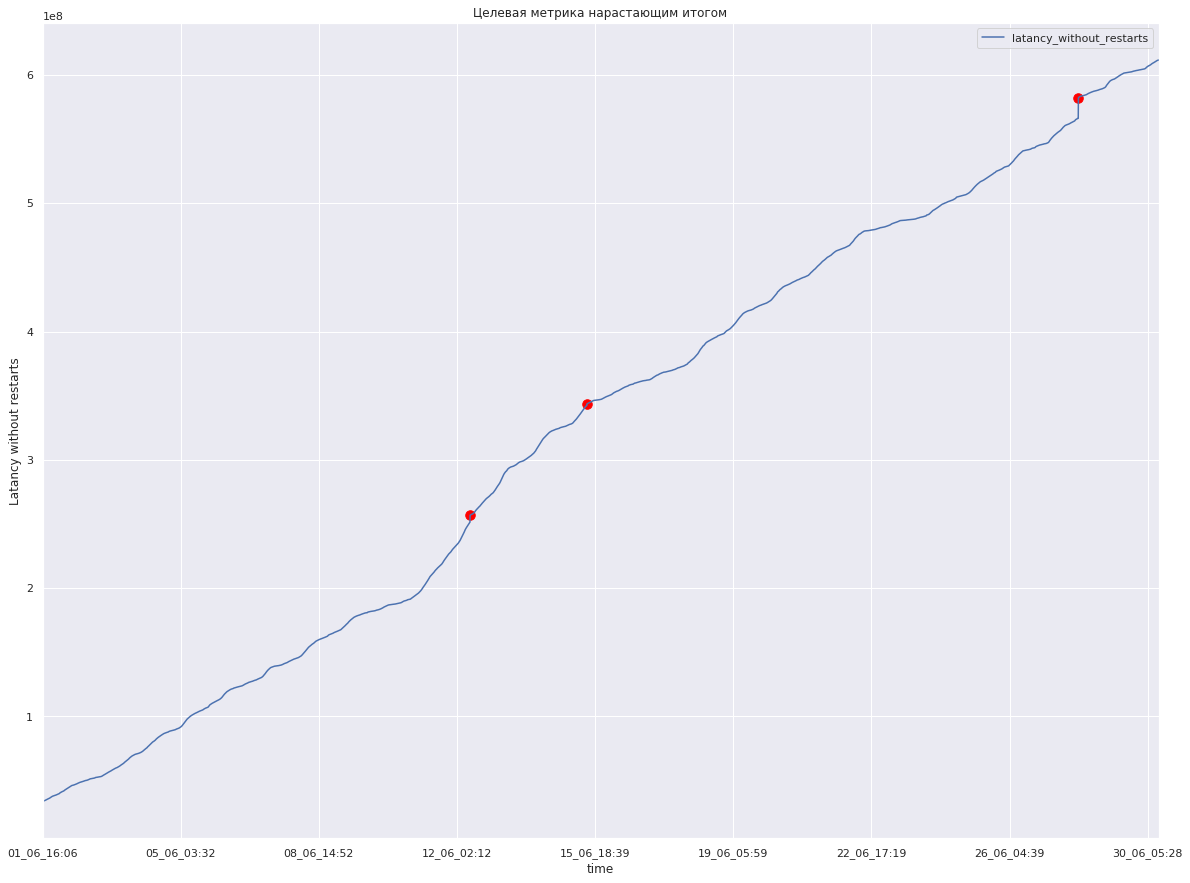

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,12_06_14:11,12_06_14:11,15472,15472,381.422411
1,15_06_13:44,15_06_13:44,19705,19705,76.864140
2,28_06_11:36,28_06_11:36,37488,37488,1107.936300




Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


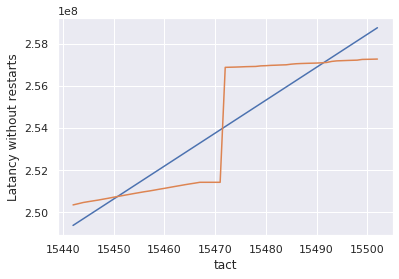

Начало аномалии: 15_06_13:44 
Конец  аномалии: 15_06_13:44 


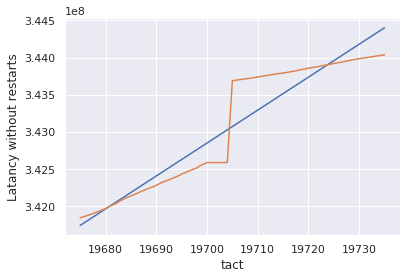

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


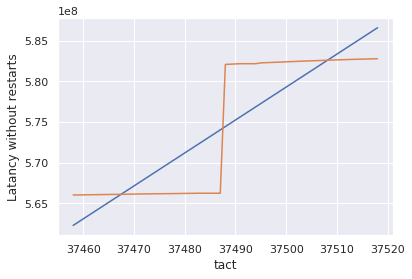

,DC,NaN,Dumps,Anomalies
0,res/au2-acs1.csv,0,1,5
1,res/eu2-acs1.csv,3,5,1
2,res/eu3-acs1.csv,0,0,3
3,res/eu5-acs1.csv,0,1,2
4,res/eu9-acs1.csv,1,4,4
5,res/jp2-acs1.csv,0,2,3
6,res/nissan.csv,0,0,3
7,res/ru2-acs1.csv,2,3,3
8,res/us2-acs1.csv,1,2,3
9,res/us3.csv,1,2,3


In [202]:
display(anomaly_result(dcs,'abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0',
                       [30,
                        60,
                        21,
                       41,
                       7,
                       20,
                       70,
                       60,
                       65,
                       26,
                       12,
                       27,
                       15],1))


### Детальный просмотр необходимого сервера:

abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0


Метрика: abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0 


Участков отсутсвия данных нет.


Моменты перезагрузки сервера:


,time
2527,03_06_13:06


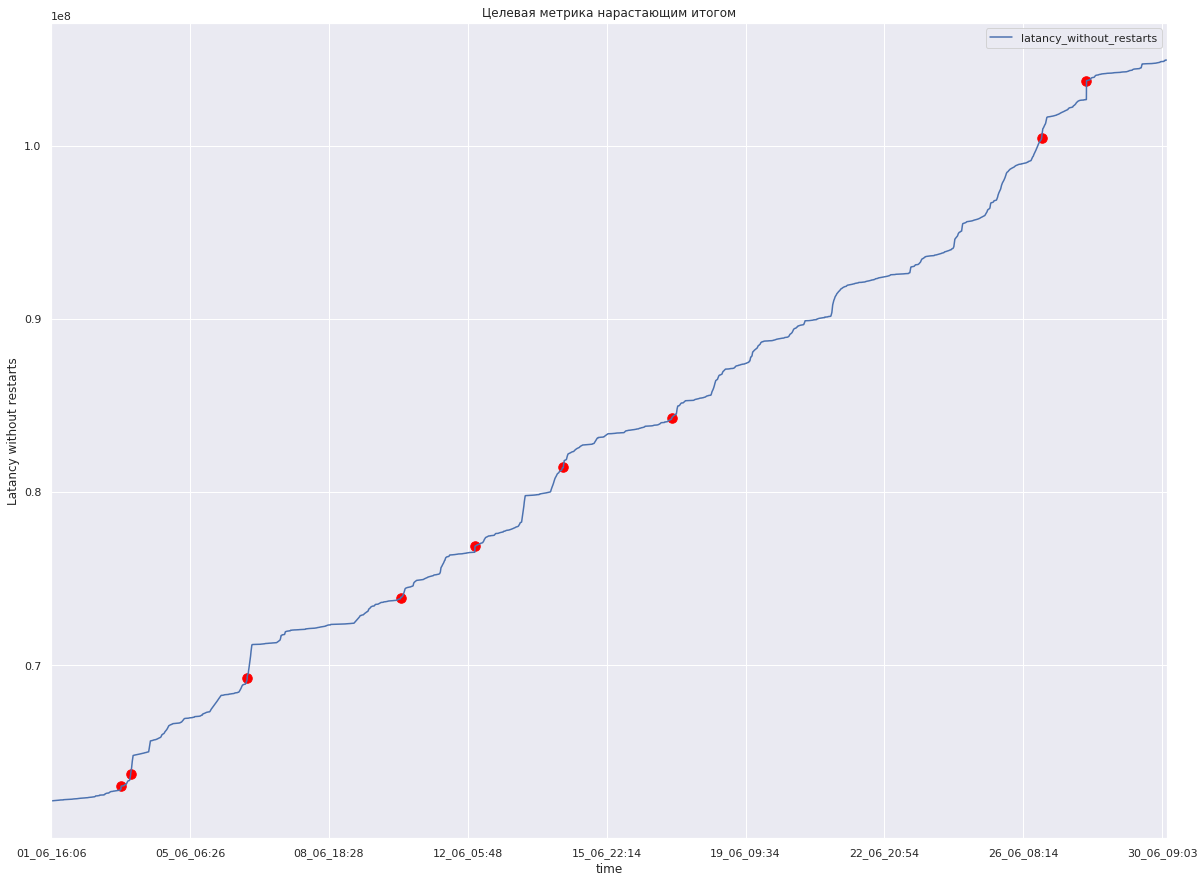

Аномалии:


,time_start,time_end,index_start,index_end,times_more
0,03_06_12:58,03_06_12:58,2519,2519,135.886022
1,03_06_18:43,03_06_18:43,2863,2863,63.432618
2,06_06_17:26,06_06_17:38,7058,7070,20.785295
3,10_06_13:31,10_06_13:33,12583,12585,15.732736
4,12_06_14:11,12_06_14:11,15256,15256,312.206069
5,14_06_19:15,14_06_19:16,18440,18441,26.581011
6,17_06_13:23,17_06_13:25,22349,22351,16.158722
7,26_06_19:15,26_06_19:27,35661,35673,16.961447
8,28_06_11:36,28_06_11:36,37273,37273,1026.693763




Начало аномалии: 03_06_12:58 
Конец  аномалии: 03_06_12:58 


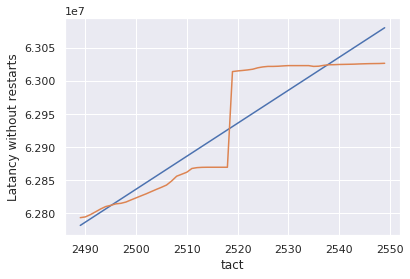

Начало аномалии: 03_06_18:43 
Конец  аномалии: 03_06_18:43 


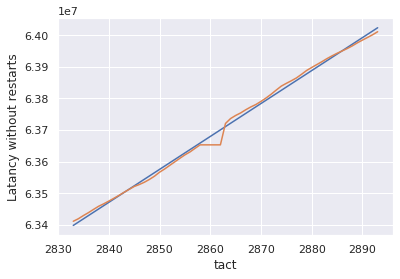

Начало аномалии: 06_06_17:26 
Конец  аномалии: 06_06_17:38 


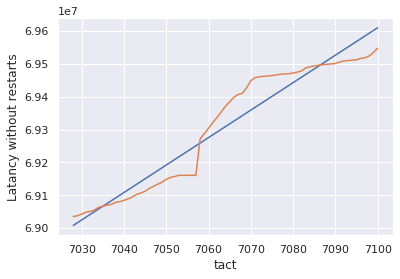

Начало аномалии: 10_06_13:31 
Конец  аномалии: 10_06_13:33 


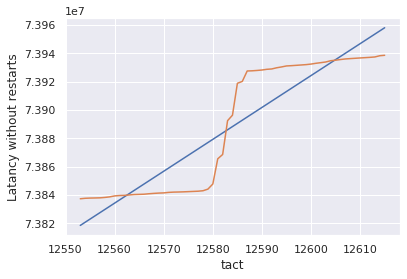

Начало аномалии: 12_06_14:11 
Конец  аномалии: 12_06_14:11 


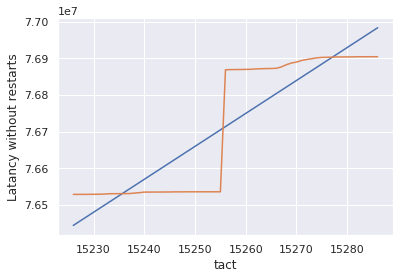

Начало аномалии: 14_06_19:15 
Конец  аномалии: 14_06_19:16 


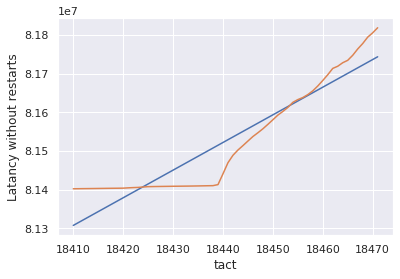

Начало аномалии: 17_06_13:23 
Конец  аномалии: 17_06_13:25 


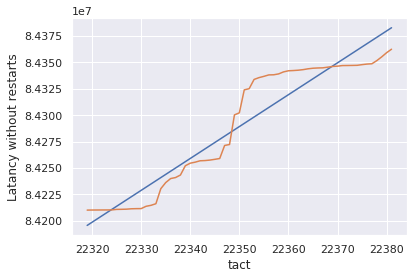

Начало аномалии: 26_06_19:15 
Конец  аномалии: 26_06_19:27 


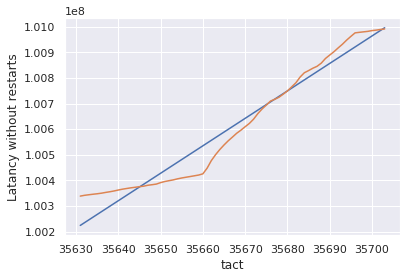

Начало аномалии: 28_06_11:36 
Конец  аномалии: 28_06_11:36 


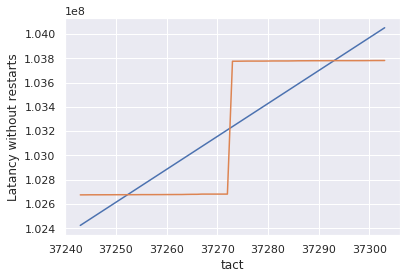

['res/au2-acs1.csv', 0, 1, 9]

In [203]:
anomaly_detection('res/au2-acs1.csv','abgw_iop_latency_ms_count_err=OK_iop=pread_proxied=0',20,1, [])